In [1]:
# ============================================
# Cell 1 – Import libraries (Classification notebook)
# --------------------------------------------
# What this cell does:
# - Imports all Python libraries we need for:
#   * Data handling (NumPy, pandas)
#   * Splitting data into train / validation / test
#   * Preprocessing (scaling numeric features, encoding categorical features)
#   * Building pipelines (preprocess + model together)
#   * Evaluating classification performance
#   * Training 4 models on the SAME classification dataset:
#       - LinearSVC
#       - Logistic Regression (correct for classification)
# ============================================

import numpy as np  # NumPy: fast numerical operations and array handling
import pandas as pd  # pandas: work with tabular data (dataframes similar to Excel tables)

from sklearn.model_selection import train_test_split  # function to split data into train / validation / test sets

from sklearn.compose import ColumnTransformer  # lets us apply different preprocessing to different columns
from sklearn.preprocessing import OneHotEncoder  # transforms categorical (text) columns into numeric dummy variables
from sklearn.preprocessing import StandardScaler  # scales numeric features (mean 0, std 1), useful for KNN and logistic regression

from sklearn.pipeline import Pipeline  # allows us to chain preprocessing and model into one pipeline object

# ---- Classification metrics ----
from sklearn.metrics import accuracy_score  # basic classification metric: fraction of correct predictions
from sklearn.metrics import classification_report  # detailed classification metrics (precision, recall, f1-score for each class)

# ---- Models we will use on the CLASSIFICATION dataset ----
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression  # Logistic Regression model (well-suited for binary classification)


In [2]:
# ============================================
# Cell 2 – Load the Heart Disease dataset
# --------------------------------------------
# What this cell does:
# - Loads the dataset from the Kaggle input directory using the correct folder name.
# - Displays the first few rows to understand the structure.
# - Prints dataset shape, data types, and missing values.
# - Confirms that the target column (HeartDisease) exists and is binary.
# ============================================

# Load the dataset (replace folder name if yours is different)
df = pd.read_csv("heart.csv")
# ^ This file path works when the dataset folder is: heart-failure-prediction

# Show the first 5 rows
df.head()

# Print dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# Show information about column types and non-null counts
df.info()

# Print missing values for each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Set the target variable for classification
target = "HeartDisease"  # 1 = disease present, 0 = no disease

# Check uniqueness of the target values
print("\nTarget variable selected:", target)
print("Unique values in target:", df[target].unique())

Dataset shape: (918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Missing values per column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR    

In [3]:
# ============================================
# Cell 3 – Separate features & target, detect feature types
# --------------------------------------------
# What this cell does:
# - Splits the DataFrame into:
#     * X = input features (all columns except the target)
#     * y = target labels (HeartDisease)
# - Checks the distribution of the target (how many 0 vs 1).
# - Automatically detects:
#     * numeric feature columns
#     * categorical feature columns
# - Prints lists of numeric and categorical columns so we know
#   what will be scaled and what will be one-hot encoded later.
# ============================================

# Separate input features (X) and target labels (y)
X = df.drop(columns=[target])  # X = all columns except HeartDisease
y = df[target]                 # y = the HeartDisease column only

# Show basic information about the target distribution (class balance)
print("Target value counts (0 = no disease, 1 = disease):")
print(y.value_counts())

# Automatically detect numeric feature columns (int or float)
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
# Automatically detect categorical feature columns (non-numeric types)
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("\nNumeric feature columns:")
print(numeric_features)

print("\nCategorical feature columns:")
print(categorical_features)

Target value counts (0 = no disease, 1 = disease):
HeartDisease
1    508
0    410
Name: count, dtype: int64

Numeric feature columns:
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

Categorical feature columns:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [4]:
# ============================================
# Cell 4 – Train / Validation / Test split (70% / 15% / 15%)
# --------------------------------------------
# What this cell does:
# - Splits our dataset into:
#       70% Training
#       15% Validation
#       15% Test
# - We first split out 15% for the TEST set.
# - Then from the remaining 85%, we calculate how much to split
#   to produce exactly 15% VALIDATION overall.
# - We use stratify=y to keep the same class balance (0/1)
#   in all splits.
# ============================================

# --- Step 1: Split OFF the Test Set (15%) ---
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,      # 15% for final test
    random_state=42,
    stratify=y           # keep 0/1 ratio consistent
)
# --- Step 2: From the remaining 85%, split Train and Validation ---
# Validation should be 15% of TOTAL.
# So inside the remaining 85%, validation proportion is:
#       0.15 / 0.85 = ~0.17647
validation_ratio = 0.15 / 0.85  # ~0.17647

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=validation_ratio,  # produces 15% overall validation
    random_state=42,
    stratify=y_temp
)

# Print out the sizes to confirm 70/15/15 split
print("Train set size:     ", X_train.shape[0], "rows")
print("Validation set size:", X_val.shape[0], "rows")
print("Test set size:      ", X_test.shape[0], "rows")

# Optional check: print percentages
total = len(df)
print("\nPercentage breakdown:")
print("Train:      ", round(X_train.shape[0] / total * 100, 2), "%")
print("Validation: ", round(X_val.shape[0] / total * 100, 2), "%")
print("Test:       ", round(X_test.shape[0] / total * 100, 2), "%")


Train set size:      642 rows
Validation set size: 138 rows
Test set size:       138 rows

Percentage breakdown:
Train:       69.93 %
Validation:  15.03 %
Test:        15.03 %


In [5]:
# ============================================
# Cell 5 – Manual Preprocessing (Ohne Pipeline)
# --------------------------------------------
# Was wir hier tun:
# 1. Wir definieren den ColumnTransformer wie vorher.
# 2. Wir wenden ihn manuell auf X_train und X_val an.
# 3. Wir machen daraus wieder schöne DataFrames mit Spaltennamen.
# ============================================

# 1. Definition der Transformer (wie vorher)
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False  # Wichtig: False, damit wir eine lesbare Tabelle (Matrix) bekommen
)

# Der Preprocessor (fasst beides zusammen)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features), 
        ("cat", categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False # Sorgt für schönere Namen ohne "num__" oder "cat__" Präfix
)

# 2. Fitten und Transformieren
# ACHTUNG: fit() darf NUR auf X_train passieren!
print("Starte Preprocessing...")

# Lernen (fit) und Anwenden (transform) auf Trainingsdaten
X_train_np = preprocessor.fit_transform(X_train)

# Nur Anwenden (transform) auf Validierungsdaten (nichts neues lernen!)
X_val_np = preprocessor.transform(X_val)

# Nur Anwenden (transform) auf Testdaten
X_test_np = preprocessor.transform(X_test)


# 3. Feature Namen retten (Wichtig für XAI!)
# Wir holen uns die Namen der neuen Spalten direkt aus dem Preprocessor
feature_names = preprocessor.get_feature_names_out()

# Wir wandeln die NumPy Arrays zurück in Pandas DataFrames
# Das macht es viel leichter zu verstehen, was passiert ist
X_train_processed = pd.DataFrame(X_train_np, columns=feature_names, index=X_train.index)
X_val_processed = pd.DataFrame(X_val_np, columns=feature_names, index=X_val.index)
X_test_processed = pd.DataFrame(X_test_np, columns=feature_names, index=X_test.index)

print("Preprocessing abgeschlossen!")
print(f"Neue Anzahl Features: {X_train_processed.shape[1]}")
print("\nSo sehen die Daten jetzt aus (erste 3 Zeilen X_train_processed):")
display(X_train_processed.head(3))

Starte Preprocessing...
Preprocessing abgeschlossen!
Neue Anzahl Features: 20

So sehen die Daten jetzt aus (erste 3 Zeilen X_train_processed):


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
43,52.0,140.0,259.0,0.0,170.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
760,53.0,123.0,282.0,0.0,95.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
255,53.0,120.0,274.0,0.0,130.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [6]:
# ============================================
# Cell 6 – Train & Evaluate Random Forest
# --------------------------------------------
# Wir nutzen nun den RandomForestClassifier, der für 
# XAI-Methoden wie SHAP oder LIME besonders spannend ist.
# ============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Modell definieren
# random_state=42 sorgt dafür, dass deine Ergebnisse reproduzierbar bleiben.
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,   # Die Bäume wachsen, bis alle Blätter rein sind
    random_state=40,
    n_jobs=-1         # Nutzt alle verfügbaren CPU-Kerne für schnelleres Training
)

# 2. Modell trainieren
# Wir nutzen weiterhin die vorverarbeiteten Daten (X_train_processed)
rf_model.fit(X_train_processed, y_train)

# 3. Vorhersagen machen
y_val_pred = rf_model.predict(X_val_processed)

# 4. Evaluieren
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Random Forest – Validation accuracy: {val_accuracy:.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_val_pred))

Random Forest – Validation accuracy: 0.8551

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        62
           1       0.87      0.87      0.87        76

    accuracy                           0.86       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.86      0.86      0.86       138



In [7]:
# ============================================
# Cell 7 – Final Evaluation on Test Set
# --------------------------------------------
# ACHTUNG: Das machen wir nur EINMAL ganz am Schluss.
# Wenn dieses Ergebnis schlecht ist, müssen wir eigentlich
# ganz von vorne anfangen (neue Features, anderes Modell),
# aber wir dürfen nicht einfach an kleinen Schräubchen drehen,
# bis dieses Ergebnis passt.
# ============================================

print("--- FINALE PRÜFUNG (Test Set) ---")

# 1. Vorhersagen auf den bereits verarbeiteten Testdaten machen
# (X_test_processed haben wir in Cell 5 schon erstellt)
y_test_pred = rf_model.predict(X_test_processed)

# 2. Genauigkeit berechnen
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Vergleich: War Validierung und Test ähnlich?
print("-" * 30)
print(f"Vergleich Accuracy: Val={val_accuracy:.4f} vs. Test={test_accuracy:.4f}")
if abs(val_accuracy - test_accuracy) < 0.05:
    print("-> Das Modell ist stabil (kein großes Overfitting).")
else:
    print("-> Vorsicht: Großer Unterschied zwischen Validierung und Test.")

--- FINALE PRÜFUNG (Test Set) ---
Test Set Accuracy: 0.8986

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        62
           1       0.90      0.92      0.91        76

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138

------------------------------
Vergleich Accuracy: Val=0.8551 vs. Test=0.8986
-> Das Modell ist stabil (kein großes Overfitting).


---

# Ziel des Projektes

Ziel des Projekts ist es, zu verstehen, wie ein Random-Forest-Modell Entscheidungen zur Herzkrankheit trifft (global & lokal) und dieses Verständnis zu nutzen, um die Modellleistung gezielt zu verbessern.

# Projektstruktur (High-Level)

| Phase | Ziel                           |
| ----- | ------------------------------ |
| 1     | Datensatz & Problemstellung    |
| 2     | Wahl der zentralen Metrik      |
| 3     | Baseline-Modell verstehen      |
| 4     | Globales XAI                   |
| 5     | Lokales XAI                    |
| 6     | Erkenntnisse → Modellanpassung |
| 7     | Vorher–Nachher-Vergleich       |
| 8     | Fazit                          |

# Phase 1: Datensatz & Problemstellung

Wir verwenden das **Heart Disease Dataset (Kaggle)**.  
Ziel ist eine **binäre Klassifikation**, bei der vorhergesagt wird, ob bei einer
Person ein Hinweis auf eine Herzkrankheit vorliegt.

---

## Zielvariable

- **`HeartDisease`**
  - `0` → kein Hinweis auf Herzkrankheit
  - `1` → Hinweis auf Herzkrankheit

---

## Problemstellung

Es soll vorhergesagt werden, ob eine Person ein erhöhtes Risiko für eine
Herzkrankheit aufweist.  
Dabei ist besonders relevant, **welche Personen als krank erkannt werden** und
**welche fälschlicherweise übersehen werden**.

---

## Relevanz im medizinischen Kontext

In medizinischen Anwendungen sind Fehlklassifikationen unterschiedlich kritisch.  
Besonders problematisch sind **False Negatives**, also Fälle, in denen
tatsächlich kranke Personen fälschlich als gesund eingestuft werden.
Solche Fehler können schwerwiegende gesundheitliche Folgen haben.

Daher ist es wichtiger, kranke Personen zuverlässig zu erkennen,
als ausschließlich eine hohe Gesamtgenauigkeit zu erzielen.

---

## Zielsetzung des Projekts

Dieses Projekt verfolgt **zwei zentrale Ziele**:

### 1️⃣ Technisches Ziel: Modellleistung verbessern

- Analyse eines Random-Forest-Modells zur Herzkrankheitsvorhersage
- Fokus auf die Reduktion kritischer Fehlklassifikationen
- Gezielte Verbesserung der Modellleistung anhand des **F2-Scores**
  (starke Gewichtung von Recall, ohne Precision vollständig zu ignorieren)

---

### 2️⃣ Inhaltliches Ziel: Modellentscheidungen verständlich machen (XAI)

Neben der reinen Leistungsoptimierung soll das Modell **erklärbar** gemacht werden:

- Verständnis, **warum** das Modell bestimmte Personen als krank oder gesund einstuft
- Transparente Darstellung der entscheidenden Merkmale
- Unterstützung von **nicht-technischen Stakeholdern**
  (z. B. Ärzt:innen, medizinisches Fachpersonal)

Insbesondere ist es relevant zu prüfen, ob das Modell:
- bekannte medizinische Risikofaktoren (z. B. Cholesterin, Blutdruck, Belastungsreaktionen)
  sinnvoll nutzt
- und ob seine Entscheidungen mit medizinischem Fachwissen übereinstimmen

Eine solche Nachvollziehbarkeit kann das **Vertrauen in KI-gestützte
Entscheidungssysteme** erhöhen und ihre Akzeptanz im klinischen Alltag fördern.

---

## Verfügbare Merkmale im Datensatz

### Numerische Merkmale

- `Age`
- `RestingBP`
- `Cholesterol`
- `FastingBS`
- `MaxHR`
- `Oldpeak`

### Kategoriale Merkmale

- `Sex`
- `ChestPainType`
- `RestingECG`
- `ExerciseAngina`
- `ST_Slope`


## Phase 2 – Wahl der zentralen Metrik

### Welche Metrik ist „am wichtigsten“?

In medizinischen Anwendungen sind Fehlklassifikationen unterschiedlich kritisch.  
Besonders problematisch ist es, **kranke Personen fälschlich als gesund einzustufen**
(**False Negative**), da dies schwerwiegende Folgen haben kann.

Aus diesem Grund ist die **Erkennung kranker Personen (Recall für HeartDisease = 1)**
ein zentraler Aspekt dieses Projekts.

Gleichzeitig sind jedoch auch **Ressourcen begrenzt**:  
Jede fälschliche Einstufung einer gesunden Person als krank (**False Positive**) kann
zu unnötigen Untersuchungen, Kosten und Belastungen führen.

Um **beide Aspekte** – hohe Erkennungsrate bei Kranken und kontrollierte Fehlalarme –
zu berücksichtigen, verwenden wir für dieses Projekt den **F2-Score** als
zentrale Bewertungsmetrik.

---

### Warum nicht Accuracy?

Accuracy misst, wie viele Vorhersagen insgesamt korrekt sind.  
In einem medizinischen Kontext ist diese Metrik jedoch nur eingeschränkt geeignet:

- False Negatives und False Positives werden gleich behandelt
- Ein einzelner übersehener Krankheitsfall kann schwerwiegender sein als mehrere Fehlalarme
- Eine hohe Accuracy kann trotz gefährlicher Fehlentscheidungen entstehen

Accuracy wird daher nur als **Kontextmetrik** betrachtet, nicht als Zielgröße.

---

### Recall – Fokus auf das Erkennen Kranker

Recall misst, wie viele tatsächlich kranke Personen korrekt erkannt werden

- **TP (True Positives):** krank → korrekt als krank erkannt  
- **FN (False Negatives):** krank → fälschlich als gesund klassifiziert  

**Interpretation:**
- Hoher Recall → wenige False Negatives  
- Niedriger Recall → viele Kranke werden übersehen  

Ein hoher Recall ist im medizinischen Kontext besonders wichtig, da er direkt die
Anzahl gefährlicher Fehlentscheidungen (False Negatives) reduziert.

---

### Warum Recall allein nicht ausreicht

Recall betrachtet **nur**, wie viele Kranke erkannt werden,  
ignoriert jedoch, wie viele **Gesunde fälschlich als krank** eingestuft werden.

Ein Modell kann einen sehr hohen Recall erreichen, indem es viele Personen
vorsichtshalber als krank klassifiziert – auch wenn ein großer Teil davon gesund ist.

Dies kann in der Praxis zu:

- unnötigen Untersuchungen
- erhöhtem Ressourcenverbrauch
- geringerer Akzeptanz des Modells

führen.

Daher ist es sinnvoll, Recall um eine Metrik zu ergänzen, die auch die Zuverlässigkeit
der positiven Vorhersagen berücksichtigt.

---

## F2-Score

Der **F2-Score** kombiniert **Precision** und **Recall**, gewichtet jedoch **Recall stärker als Precision**.


### Formel für den F2-Score ($\beta = 2$)

$$
F_2 = 5 \cdot \frac{\text{Precision} \cdot \text{Recall}}
{(4 \cdot \text{Precision}) + \text{Recall}}
$$

### Definitionen

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

### Was bedeutet F2 konkret?

Der F2-Score beantwortet die Frage:

> *Wie gut erkennt das Modell kranke Personen,  
> während gleichzeitig berücksichtigt wird, wie zuverlässig diese Vorhersagen sind?*

Eigenschaften des F2-Scores:
- Recall wird **stärker gewichtet** als Precision
- False Negatives bleiben der kritischste Fehler
- False Positives werden jedoch nicht vollständig ignoriert

---

### Was optimieren wir damit konkret?

**Ziel:**
- False Negatives deutlich reduzieren  
- False Positives bewusst in Kauf nehmen – aber nicht unbegrenzt  

Der F2-Score erlaubt es, diese beiden Aspekte **gemeinsam** zu bewerten.

Recall bleibt dabei die **inhaltlich wichtigste Komponente**,  
der F2-Score dient als **übergeordnete Bewertungsmetrik** für Modellentscheidungen
und den späteren Vorher–Nachher-Vergleich.


## Phase 3 – Baseline-Modell & erste Leistungsbewertung (Vorher-Zustand)

### Ziel dieser Phase
In dieser Phase bestimmen wir die **Baseline-Performance** unseres Random-Forest-Modells.  
Diese Baseline dient als **Referenz** für alle späteren **XAI-gestützten Modellanpassungen**.

---

### Baseline-Setup
- **Modell:** Random Forest  
- **Preprocessing:**
  - Kategoriale Features → **One-Hot-Encoding**
  - Numerische Features → **unverändert (passthrough)**
- **Entscheidungsschwelle:** **0.5** (Standard)

---


### Confusion Matrix (Baseline / vorher)

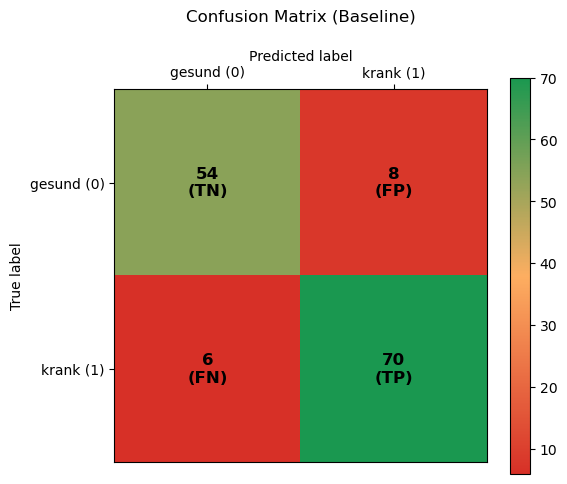

In [8]:
from matplotlib.colors import LinearSegmentedColormap

cmap_traffic = LinearSegmentedColormap.from_list(
    "traffic_light",
    ["#d73027", "#fdae61", "#1a9850"]  # rot, orange, grün
)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

cm = np.array([[54, 8],
               [6, 70]])

labels = ["gesund (0)", "krank (1)"]

# Colormap
cmap_traffic = LinearSegmentedColormap.from_list(
    "traffic_light",
    ["#d73027", "#fdae61", "#1a9850"]
)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap=cmap_traffic)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):

        if i == 0 and j == 0:
            label = "(TN)"
        elif i == 0 and j == 1:
            label = "(FP)"
        elif i == 1 and j == 0:
            label = "(FN)"
        elif i == 1 and j == 1:
            label = "(TP)"

        ax.text(
            j, i,
            f"{cm[i, j]}\n{label}",
            ha="center", va="center",
            color="black",
            fontsize=12,
            fontweight="bold"
        )


# Achsenbeschriftung
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

# X-Achse nach oben
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (Baseline)", pad=20)

# Colorbar
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


---

### Identifikation und Charakterisierung kritischer Fehlklassifikationen


In [9]:
# Klassen-Vorhersagen (Standard-Schwelle 0.5)
y_pred = rf_model.predict(X_test_processed)

# Wahrscheinlichkeiten (für später, z. B. XAI)
y_proba = rf_model.predict_proba(X_test_processed)[:, 1]

#### False Negatives (Untersuchungsobjekt)

In [10]:
# False Negatives: krank (1), aber als gesund (0) vorhergesagt
fn_mask = (y_test == 1) & (y_pred == 0)

# Anzahl False Negatives
num_fn = int(np.sum(fn_mask))
print("Anzahl False Negatives:", num_fn)

Anzahl False Negatives: 6


In [11]:
fn_cases = X_test_processed[fn_mask].copy()
fn_cases["y_true"] = y_test[fn_mask].values
fn_cases["y_pred"] = y_pred[fn_mask]
fn_cases["y_proba"] = y_proba[fn_mask]
display(fn_cases)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,y_true,y_pred,y_proba
684,47.0,108.0,243.0,0.0,152.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.00
889,59.0,134.0,204.0,0.0,162.0,0.8,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.08
759,54.0,192.0,283.0,0.0,195.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.21
763,58.0,132.0,224.0,0.0,173.0,3.2,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.25
440,52.0,128.0,0.0,0.0,180.0,3.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0,0.41
1,49.0,160.0,180.0,0.0,156.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0.27


#### True Positives (Referenz)

In [12]:

# True Positives: krank (1) und korrekt als krank vorhergesagt
tp_mask = (y_test == 1) & (y_pred == 1)

# Anzahl True Positives
num_tp = int(np.sum(tp_mask))
print("Anzahl True Positives:", num_tp)

Anzahl True Positives: 70


In [13]:
tp_cases = X_test_processed[tp_mask].copy()
tp_cases["y_true"] = y_test[tp_mask].values
tp_cases["y_pred"] = y_pred[tp_mask]
tp_cases["y_proba"] = y_proba[tp_mask]
display(tp_cases)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,y_true,y_pred,y_proba
615,70.0,130.0,322.0,0.0,109.0,2.4,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
383,38.0,110.0,0.0,0.0,156.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
316,57.0,105.0,0.0,1.0,148.0,0.3,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.69
351,43.0,140.0,0.0,0.0,140.0,0.5,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.76
546,48.0,132.0,220.0,1.0,162.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1,1,0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,54.0,136.0,220.0,0.0,140.0,3.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,1.00
313,34.0,115.0,0.0,1.0,154.0,0.2,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0.59
238,48.0,160.0,355.0,0.0,99.0,2.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.98
242,55.0,160.0,292.0,1.0,143.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.92


In [14]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

display(tp_cases)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,y_true,y_pred,y_proba
615,70.0,130.0,322.0,0.0,109.0,2.4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
383,38.0,110.0,0.0,0.0,156.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.67
316,57.0,105.0,0.0,1.0,148.0,0.3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.69
351,43.0,140.0,0.0,0.0,140.0,0.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.76
546,48.0,132.0,220.0,1.0,162.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1,1,0.68
132,56.0,170.0,388.0,0.0,122.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1,0.97
481,69.0,140.0,0.0,1.0,118.0,2.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,1,0.72
622,59.0,110.0,239.0,0.0,142.0,1.2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,0.84
398,52.0,165.0,0.0,1.0,122.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,1,0.75
596,57.0,122.0,264.0,0.0,100.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0.82


#### Vergleich der vorhergesagten Krankheitswahrscheinlichkeiten (FN vs. TP)

In [15]:
print("FN y_proba summary:")
print(fn_cases["y_proba"].describe())

print("\nTP y_proba summary:")
print(tp_cases["y_proba"].describe())

FN y_proba summary:
count    6.000000
mean     0.203333
std      0.145556
min      0.000000
25%      0.112500
50%      0.230000
75%      0.265000
max      0.410000
Name: y_proba, dtype: float64

TP y_proba summary:
count    70.000000
mean      0.833429
std       0.136529
min       0.530000
25%       0.720000
50%       0.845000
75%       0.967500
max       1.000000
Name: y_proba, dtype: float64


Die y_proba-Verteilungen zeigen eine starke Trennung: True Positives liegen fast immer deutlich über 0.5 (Median ≈ 0.845), während die wenigen False Negatives sehr niedrige Krankheitswahrscheinlichkeiten erhalten (Max ≈ 0.41). Damit sind die False Negatives keine reinen Grenzfälle, sondern Fälle, bei denen das Modell das Risiko strukturell unterschätzt – ein guter Ausgangspunkt für lokale XAI-Erklärungen und anschließende Modellanpassungen (z. B. class_weight, Feature-Logik).

---

### Baseline-Metriken

In [16]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, fbeta_score

recall = recall_score(y_test, y_pred, pos_label=1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=1)

print("Recall (HeartDisease = 1):", round(recall, 4))
print("Precision (HeartDisease = 1):", round(precision, 4))
print("F2-Score (HeartDisease = 1):", round(f2, 4))
print("Accuracy:", round(accuracy, 4))

Recall (HeartDisease = 1): 0.9211
Precision (HeartDisease = 1): 0.8974
F2-Score (HeartDisease = 1): 0.9162
Accuracy: 0.8986


---

# Phase 4: Globales XAI

---

# Phase 5: Lokales XAI

## Auswahl der Vergleichsgruppen

Um lokale Erklärungen besser interpretieren zu können, vergleichen wir False-Negative-Fälle mit möglichst ähnlichen True-Positive-Fällen. Dadurch isolieren wir die Merkmale, die die Modellentscheidung kippen, anstatt völlig unterschiedliche Patientenprofile zu vergleichen.

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# ============================================================
# kNN-MATCHING: FN mit ähnlichsten TP im Feature-Space
# ============================================================

# 1) Echte Feature-Spalten definieren (aus processed Matrix!)
feature_cols = X_train_processed.columns.tolist()

# numeric_features muss bei dir existieren und genau diese Spaltennamen enthalten:
num_cols = numeric_features
cat_cols = [c for c in feature_cols if c not in num_cols]

# 2) Scaler NUR auf TRAIN fitten
scaler = StandardScaler()
scaler.fit(X_train_processed[num_cols])

# 3) Hilfsfunktion: Feature-Matrix für kNN bauen (ohne y_true/y_pred/y_proba)
def build_knn_matrix(df):
    X = df[feature_cols]  # nur echte Features
    X_num = scaler.transform(X[num_cols])
    X_cat = X[cat_cols].values
    return np.hstack([X_num, X_cat])

# 4) Matrizen bauen
X_fn = build_knn_matrix(fn_cases)
X_tp = build_knn_matrix(tp_cases)

fn_idx = fn_cases.index.to_list()
tp_idx = tp_cases.index.to_list()

# 5) kNN: für jeden FN die k ähnlichsten TP finden
k = 3
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_tp)

distances, indices = nn.kneighbors(X_fn)

# 6) Ergebnis-Tabelle
rows = []
for i, fn_id in enumerate(fn_idx):
    for r in range(k):
        tp_id = tp_idx[indices[i, r]]
        rows.append({
            "fn_id": fn_id,
            "tp_id": tp_id,
            "rank": r + 1,
            "distance": float(distances[i, r]),
            "fn_proba": float(fn_cases.loc[fn_id, "y_proba"]),
            "tp_proba": float(tp_cases.loc[tp_id, "y_proba"]),
        })

knn_matches_df = pd.DataFrame(rows).sort_values(["fn_id","rank"]).reset_index(drop=True)
knn_matches_df



,fn_id,tp_id,rank,distance,fn_proba,tp_proba
0,1,264,1,2.310927,0.27,0.72
1,1,281,2,2.647454,0.27,0.97
2,1,735,3,2.779110,0.27,0.62
3,440,492,1,2.432686,0.41,0.70
4,440,735,2,3.261938,0.41,0.62
5,440,337,3,3.459791,0.41,0.69
6,684,104,1,2.391920,0.00,0.98
7,684,131,2,2.484117,0.00,0.88
8,684,735,3,2.539645,0.00,0.62
9,759,581,1,4.267965,0.21,0.74


In [18]:
# ==== Vorhersagen auf Testset (processed) ====
y_pred = rf_model.predict(X_test_processed)
y_proba = rf_model.predict_proba(X_test_processed)[:, 1]   # Wahrscheinlichkeit für Klasse 1



In [19]:
# Masken
fn_mask = (y_test == 1) & (y_pred == 0)
tp_mask = (y_test == 1) & (y_pred == 1)

# DataFrames
fn_cases = X_test_processed.loc[fn_mask].copy()
tp_cases = X_test_processed.loc[tp_mask].copy()

# Labels + proba dazupacken
fn_cases["y_true"] = y_test.loc[fn_mask].values
fn_cases["y_pred"] = y_pred[fn_mask]
fn_cases["y_proba"] = y_proba[fn_mask]

tp_cases["y_true"] = y_test.loc[tp_mask].values
tp_cases["y_pred"] = y_pred[tp_mask]
tp_cases["y_proba"] = y_proba[tp_mask]

print("FN:", fn_cases.shape[0], "TP:", tp_cases.shape[0])
display(fn_cases[["y_proba"]].describe())
display(tp_cases[["y_proba"]].describe())


FN: 6 TP: 70


,y_proba
count,6.000000
mean,0.203333
std,0.145556
min,0.000000
25%,0.112500
50%,0.230000
75%,0.265000
max,0.410000


,y_proba
count,70.000000
mean,0.833429
std,0.136529
min,0.530000
25%,0.720000
50%,0.845000
75%,0.967500
max,1.000000


In [20]:
import shap
import numpy as np

shap.initjs()
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_test_processed)
base_value = explainer.expected_value

# --- Robust auf "list" vs "3D array" reagieren ---
if isinstance(shap_values, list):
    # klassisch: [class0, class1]
    shap_values_1 = shap_values[1]              # (n_samples, n_features)
    base_value_1 = base_value[1] if isinstance(base_value, (list, np.ndarray)) else base_value
else:
    # neu/anders: (n_samples, n_features, n_classes)
    if shap_values.ndim == 3:
        shap_values_1 = shap_values[:, :, 1]    # Klasse 1 -> (n_samples, n_features)
    else:
        shap_values_1 = shap_values             # fallback (sollte dann schon 2D sein)

    if isinstance(base_value, (list, np.ndarray)) and np.ndim(base_value) > 0:
        base_value_1 = base_value[1]
    else:
        base_value_1 = base_value



C:\Users\ayhan\anaconda3\envs\shap_clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import shap


def get_shap_row(idx):
    row_pos = X_test_processed.index.get_loc(idx)
    x_row = X_test_processed.loc[idx]
    s_row = shap_values_1[row_pos].ravel()  # ravel() stellt sicher, dass es 1D ist
    return row_pos, x_row, s_row


def plot_waterfall(idx, title):
    row_pos, x_row, s_row = get_shap_row(idx)

    exp = shap.Explanation(
        values=s_row,
        base_values=base_value_1,
        data=x_row.values,
        feature_names=X_test_processed.columns
    )

    plt.figure()
    shap.plots.waterfall(exp, max_display=15, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def compare_fn_to_tps(fn_id, k=3):
    # passende TPs holen
    matches = (
        knn_matches_df[knn_matches_df["fn_id"] == fn_id]
        .sort_values("rank")
        .head(k)
    )

    tp_ids = matches["tp_id"].tolist()

    print(
        "FN:", fn_id,
        "proba:", float(fn_cases.loc[fn_id, "y_proba"])
    )
    display(matches)

    # 1) Waterfall für FN
    plot_waterfall(
        fn_id,
        f"FN {fn_id} (p={fn_cases.loc[fn_id, 'y_proba']:.3f})"
    )

    # 2) Waterfall für die k ähnlichsten TPs
    for tp_id in tp_ids:
        plot_waterfall(
            tp_id,
            f"TP {tp_id} (p={tp_cases.loc[tp_id, 'y_proba']:.3f})"
        )


## 1) FN_ID: 684

In [37]:
import numpy as np
import pandas as pd

# ============================================================
# Helper (wie bei dir)
# ============================================================
def _get_row_pos(idx):
    return X_test_processed.index.get_loc(idx)

def _get_shap_vector(idx):
    row_pos = _get_row_pos(idx)
    s = shap_values_1[row_pos].ravel()
    return s


# ============================================================
# Vergleichstabelle: Top-N Features nach |FN_SHAP| + Werte (val)
# ============================================================
import numpy as np
import pandas as pd

def make_waterfall_compare_table(fn_id, k=3, sort_by="abs_delta", ascending=False):
    """
    Gibt eine Tabelle für FN vs k ähnlichste TPs zurück:
    - ALLE Features (jede Zeile ein Feature)
    - pro Sample: Feature-Wert (_val) + SHAP (_SHAP)
    - meanTP_SHAP + Delta_FN_minus_meanTP
    """

    # 1) passende TPs holen
    matches = (knn_matches_df[knn_matches_df["fn_id"] == fn_id]
               .sort_values("rank")
               .head(k))
    tp_ids = matches["tp_id"].tolist()

    # 2) SHAP-Vektoren ziehen (alle Features)
    row_fn = X_test_processed.index.get_loc(fn_id)
    fn_shap = shap_values_1[row_fn].ravel()  # (n_features,)

    tp_shaps = []
    for tp_id in tp_ids:
        row_tp = X_test_processed.index.get_loc(tp_id)
        tp_shaps.append(shap_values_1[row_tp].ravel())

    tp_shaps = np.vstack(tp_shaps)              # (k, n_features)
    mean_tp_shap = tp_shaps.mean(axis=0)        # (n_features,)

    # 3) Feature-Werte (alle Features)
    feature_names = X_test_processed.columns.tolist()

    fn_vals = X_test_processed.loc[fn_id, feature_names].values
    tp_vals_list = [X_test_processed.loc[tp_id, feature_names].values for tp_id in tp_ids]

    # 4) Delta
    delta = fn_shap - mean_tp_shap
    abs_delta = np.abs(delta)

    # 5) DataFrame bauen (ALLE Features)
    data = {
        "feature": feature_names,
        "FN_val": fn_vals,
        "FN_SHAP": fn_shap,
    }

    for j, tp_id in enumerate(tp_ids, start=1):
        data[f"TP{j}_{tp_id}_val"] = tp_vals_list[j-1]
        data[f"TP{j}_{tp_id}_SHAP"] = tp_shaps[j-1]

    df = pd.DataFrame(data)
    df["meanTP_SHAP"] = mean_tp_shap
    df["Delta_FN_minus_meanTP"] = delta
    df["abs_delta"] = abs_delta
    df["delta_sign"] = np.sign(delta).astype(int)
    df["fn_id"] = fn_id

    # 6) Werte hübsch formatieren:
    #    - Binäre Features (OHE etc.) als int 0/1
    #    - andere numerische Features bleiben float
    val_cols = [c for c in df.columns if c.endswith("_val")]
    for c in val_cols:
        col = pd.to_numeric(df[c], errors="coerce")
        uniq = set(col.dropna().unique().tolist())
        if uniq.issubset({0, 1}):
            df[c] = col.round(0).astype("Int64")  # 0/1 als int
        else:
            df[c] = col.astype(float)             # numerisch lassen

    # SHAP-Spalten runden
    shap_cols = [c for c in df.columns if c.endswith("_SHAP")] + ["meanTP_SHAP", "Delta_FN_minus_meanTP", "abs_delta"]
    shap_cols = list(dict.fromkeys(shap_cols))  # duplicates raus (verhindert deinen alten Fehler)
    df.loc[:, shap_cols] = df[shap_cols].astype(float).round(3)

    # 7)
    # Standard: sortiere wie Waterfall nach |FN_SHAP|
    df = df.sort_values(by="FN_SHAP", key=np.abs, ascending=False).reset_index(drop=True)


    # Wenn du "abs_delta" & "delta_sign" nicht sehen willst, einfach am Ende droppen.
    return df, matches


    # ============================================================
    # >>> HIER IST DIE WICHTIGE STELLE (Fix für deinen Fehler) <<<
    # ============================================================

    val_cols  = [c for c in df.columns if c.endswith("_val")]
    shap_cols = [c for c in df.columns if c.endswith("_SHAP")] + ["meanTP_SHAP", "Delta_FN_minus_meanTP"]

    # 1) Duplikate aus shap_cols entfernen (sonst: "Columns must be same length as key")
    shap_cols = list(dict.fromkeys(shap_cols))  # <- DAS ist der Fix

    # 2) Werte-Spalten: wenn OHE -> schön als int (0/1). Bei numerischen Features bleiben’s dann halt z.B. 152.
    df[val_cols] = df[val_cols].round(0).astype(int)

    # 3) SHAP-Spalten sauber numerisch runden (robust)
    df[shap_cols] = df[shap_cols].apply(pd.to_numeric, errors="coerce").round(3)

    return df, matches


# ============================================================
# B) Decision Plot für genau diese Gruppe (FN + k TPs)
# ============================================================

def plot_decision_for_fn_group(fn_id, k=3, title_prefix="Decision Plot"):
    matches = (
        knn_matches_df[knn_matches_df["fn_id"] == fn_id]
        .sort_values("rank")
        .head(k)
    )

    tp_ids = matches["tp_id"].tolist()

    idxs = [fn_id] + tp_ids
    row_positions = [_get_row_pos(i) for i in idxs]

    shap_subset = shap_values_1[row_positions, :]
    X_subset = X_test_processed.loc[idxs]

    plt.figure()
    shap.decision_plot(
        base_value_1,
        shap_subset,
        X_subset,
        feature_names=X_test_processed.columns.tolist(),
        show=False
    )
    plt.title(f"{title_prefix}: FN {fn_id} vs {k} similar TPs")
    plt.tight_layout()
    plt.show()

    return matches


## Lokale XAI-Analyse eines False-Negative-Falls (ID 684)

FN 684 p(krank) = 0.0


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
6,684,104,1,2.391920,0.0,0.98
7,684,131,2,2.484117,0.0,0.88
8,684,735,3,2.539645,0.0,0.62


FN: 684 proba: 0.0


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
6,684,104,1,2.391920,0.0,0.98
7,684,131,2,2.484117,0.0,0.88
8,684,735,3,2.539645,0.0,0.62


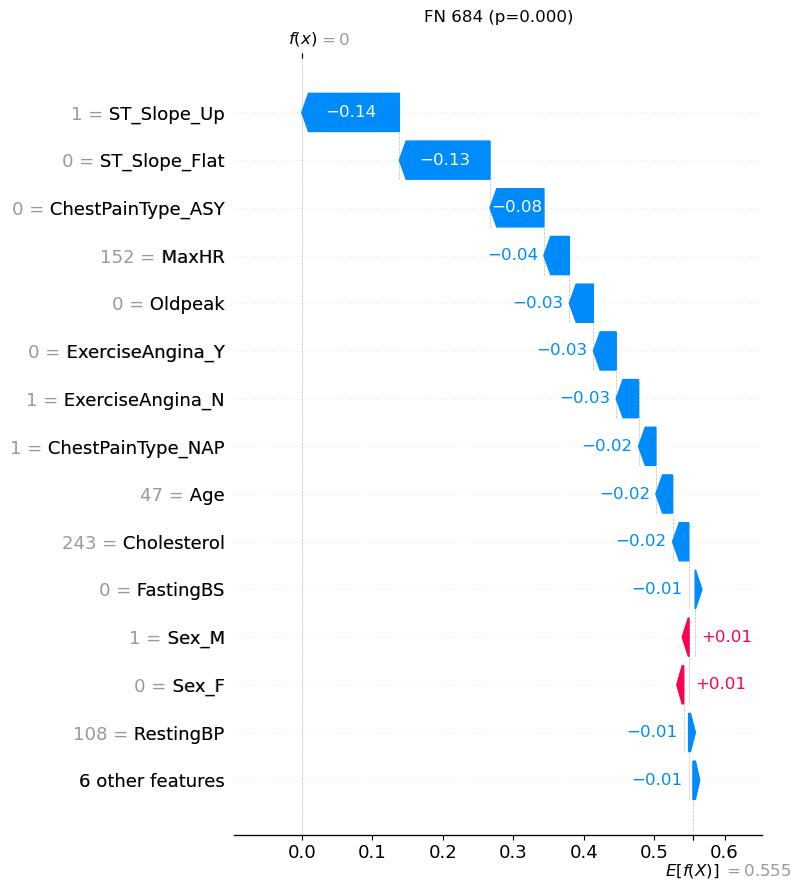

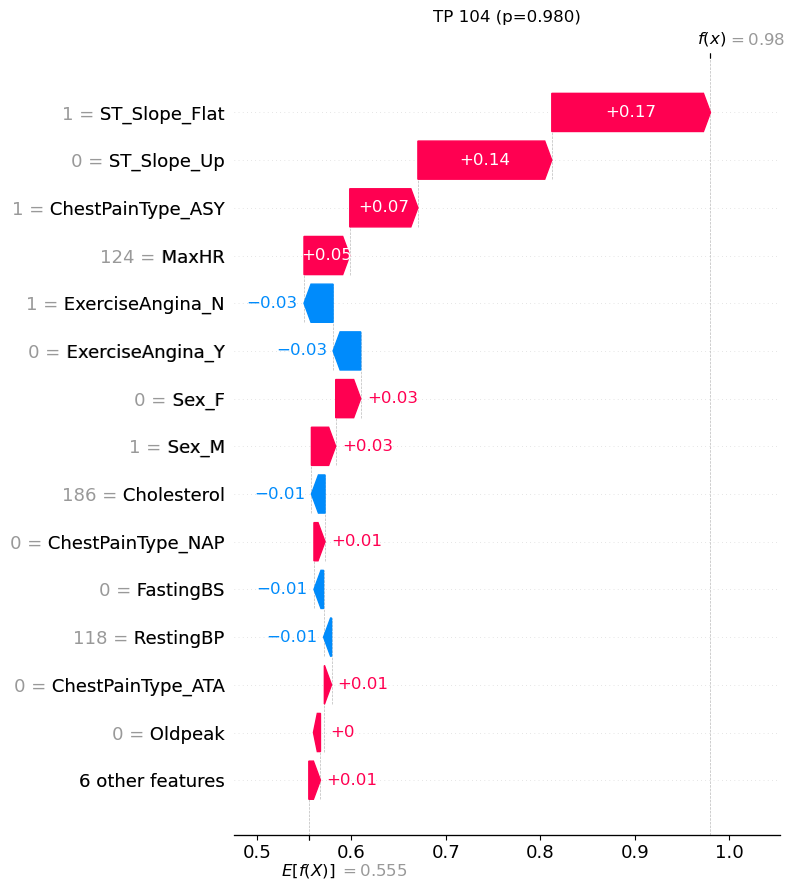

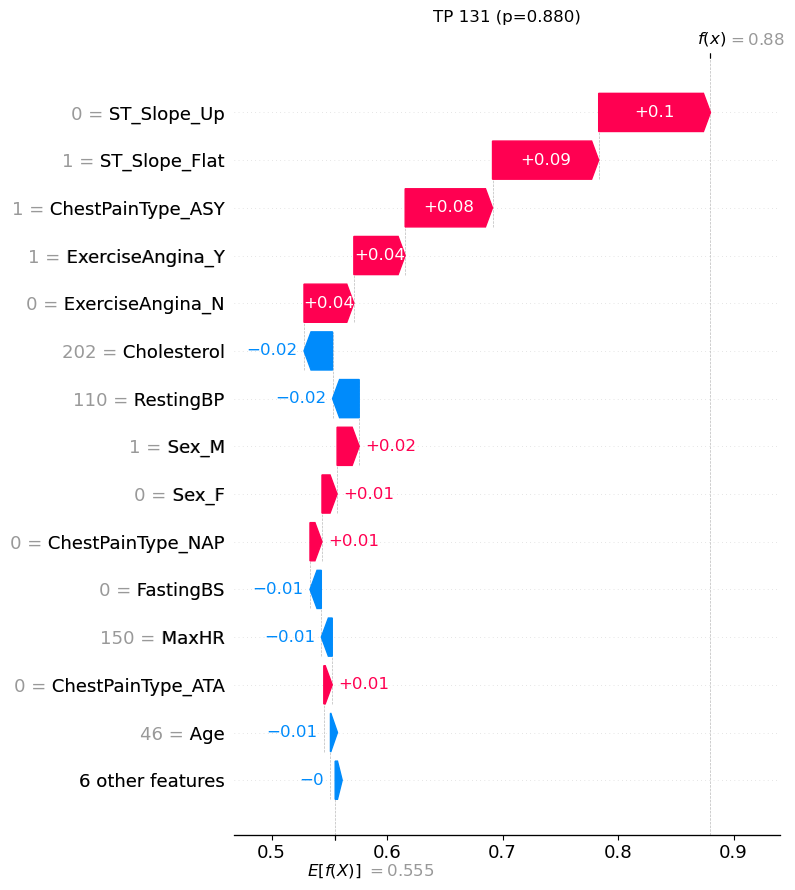

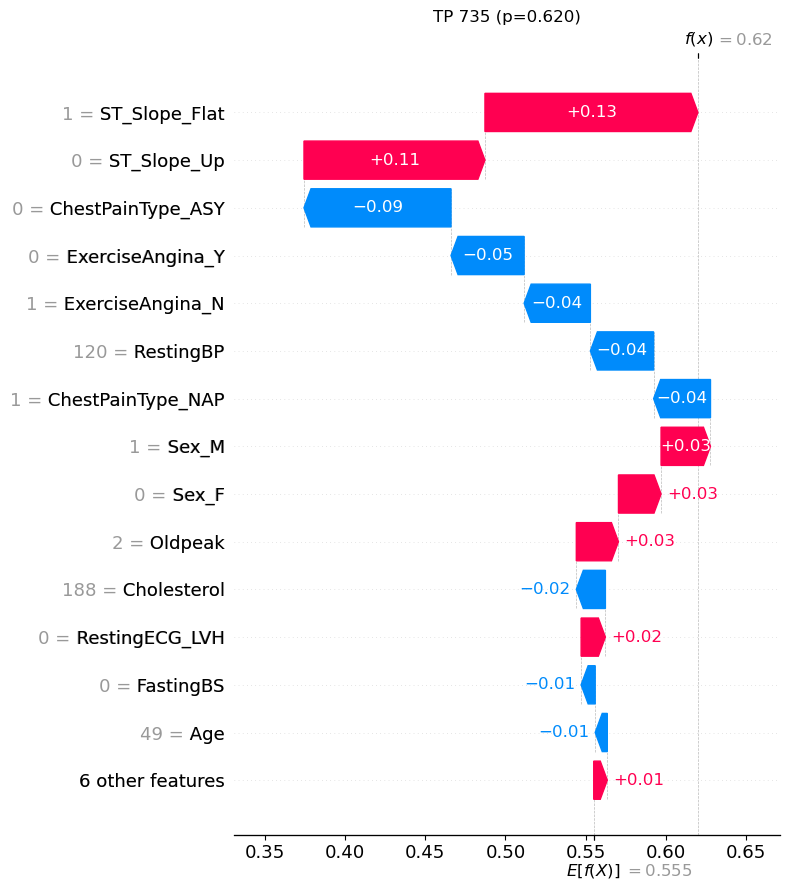

,feature,FN_val,FN_SHAP,TP1_104_val,TP1_104_SHAP,TP2_131_val,TP2_131_SHAP,TP3_735_val,TP3_735_SHAP,meanTP_SHAP,Delta_FN_minus_meanTP,abs_delta,delta_sign,fn_id
0,ST_Slope_Up,1.0,-0.138,0.0,0.142,0.0,0.097,0.0,0.113,0.117,-0.256,0.256,-1,684
1,ST_Slope_Flat,0.0,-0.129,1.0,0.168,1.0,0.092,1.0,0.133,0.131,-0.259,0.259,-1,684
2,ChestPainType_ASY,0.0,-0.076,1.0,0.072,1.0,0.076,0.0,-0.092,0.019,-0.095,0.095,-1,684
3,MaxHR,152.0,-0.036,124.0,0.048,150.0,-0.009,139.0,0.004,0.014,-0.050,0.050,-1,684
4,Oldpeak,0.0,-0.034,0.0,0.004,0.0,-0.005,2.0,0.026,0.009,-0.043,0.043,-1,684
5,ExerciseAngina_N,1.0,-0.032,1.0,-0.031,0.0,0.043,1.0,-0.041,-0.010,-0.022,0.022,-1,684
6,ExerciseAngina_Y,0.0,-0.032,0.0,-0.029,1.0,0.044,0.0,-0.046,-0.010,-0.022,0.022,-1,684
7,ChestPainType_NAP,1.0,-0.025,0.0,0.012,0.0,0.010,1.0,-0.035,-0.004,-0.020,0.020,-1,684
8,Age,47.0,-0.024,46.0,0.003,46.0,-0.006,49.0,-0.008,-0.003,-0.020,0.020,-1,684
9,Cholesterol,243.0,-0.023,186.0,-0.014,202.0,-0.025,188.0,-0.018,-0.019,-0.004,0.004,-1,684


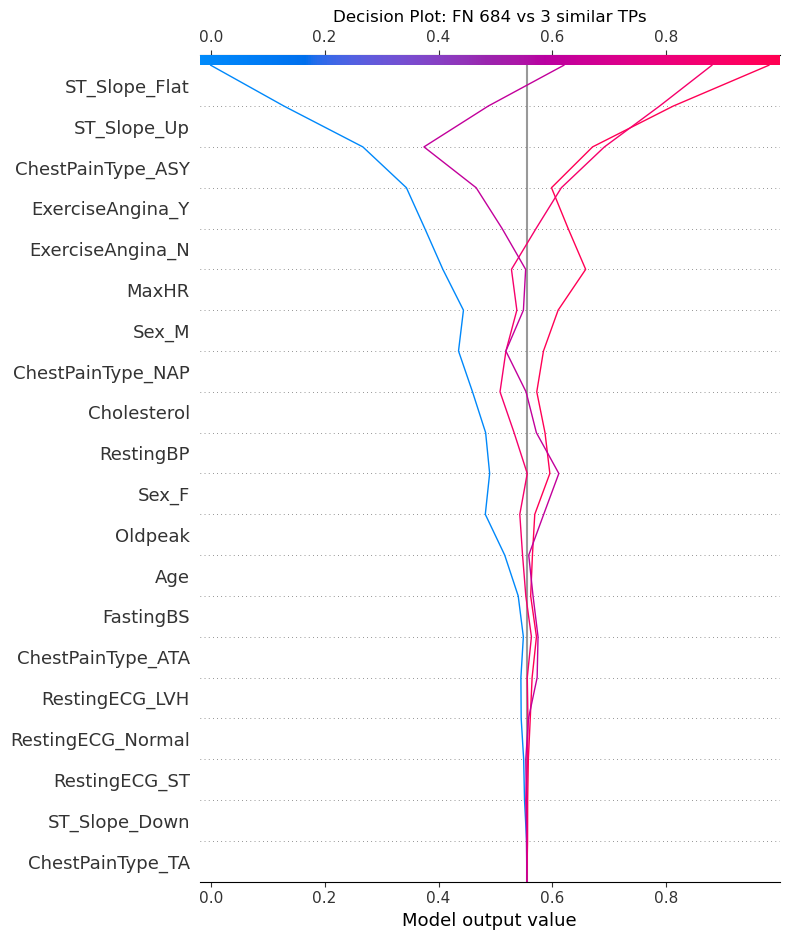

In [38]:
fn_id = 684

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table, matches2 = make_waterfall_compare_table(fn_id, k=3)

print(f"FN {fn_id} p(krank) =", float(fn_cases.loc[fn_id, "y_proba"]))
display(matches2)          # oder display(matches2[["fn_id","tp_id","rank","distance","tp_proba"]]) etc.
# Beispiel: nimm den FN mit der niedrigsten proba (oft spannend)
fn_id_example = fn_cases.sort_values("y_proba").index[0]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   # Tabelle zuerst

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)


## Lokale XAI-Analyse eines False-Negative-Falls (ID 684)

Im Folgenden analysieren wir exemplarisch den False-Negative-Fall **ID 684**, um zu verstehen, warum das Modell eine tatsächlich kranke Person mit sehr hoher Sicherheit als gesund einstuft (`p(krank) = 0.00`). Ziel dieser Analyse ist es, **an einem konkreten Beispiel** zu zeigen, wie lokale XAI-Erklärungen (Waterfall-Tabelle und Decision Plot) zu interpretieren sind.

Die Analyse erfolgt **nicht isoliert**, sondern im Vergleich zu **drei sehr ähnlichen True-Positive-Fällen**, die vom Modell korrekt als krank erkannt wurden. Dadurch lässt sich untersuchen, **welche Merkmale die Modellentscheidung kippen**, obwohl die Patienten im Feature-Space ähnlich sind. Die Erkenntnisse aus diesem Einzelfall werden anschließend **über alle False Negatives hinweg aggregiert**, anstatt jeden Fehlfall einzeln ausführlich zu diskutieren.

---

## Das Feature *ST_Slope* – medizinischer Hintergrund

In der folgenden Untersuchung werden wir insbesondere das Feature **ST_Slope** angucken, da es sowohl beim **FN**, als auch be iden **TPs** den höchsten SHAP-Wert aufzeigt. Das Feature beschreibt das Verhalten der ST-Strecke im Belastungs-EKG. Vereinfacht gilt:

- **ST_Slope_Up (ansteigend)** → meist unauffällig  
- **ST_Slope_Flat (flach)** → auffällig  
- **ST_Slope_Down (abfallend)** → stark auffällig, hohes Risiko  

Medizinisch betrachtet ist **ST_Slope_Down** das deutlichste Warnsignal, während **ST_Slope_Up** eher als harmlos gilt und **ST_Slope_Flat** eine Zwischenstufe darstellt.

---

## Repräsentation von *ST_Slope* im Modell (One-Hot-Encoding)

Das kategoriale Merkmal *ST_Slope* wird mittels **One-Hot-Encoding (OHE)** in drei binäre Spalten überführt:

- `ST_Slope_Up`
- `ST_Slope_Flat`
- `ST_Slope_Down`

Dabei ist pro Patient **genau eine dieser Spalten auf 1 gesetzt**, die übrigen haben den Wert 0.

Für Patient **684** gilt:
- `ST_Slope_Up = 1`
- `ST_Slope_Flat = 0`
- `ST_Slope_Down = 0`

Das Modell verarbeitet somit **kein medizinisches Label**, sondern ein **konkretes Muster aus binären Eingaben**, das es während des Trainings mit Zielwerten verknüpft hat.

---

## Interpretation der Waterfall-Tabelle (lokale SHAP-Werte)

Die Waterfall-Tabelle stellt gegenüber:
- die SHAP-Werte des False-Negative-Falls,
- die SHAP-Werte der drei ähnlichsten True Positives,
- sowie die Differenz zwischen False Negative und durchschnittlichem True Positive.

Dabei gilt:
- **Negative SHAP-Werte** verschieben die Vorhersage in Richtung *„gesund“*
- **Positive SHAP-Werte** verschieben die Vorhersage in Richtung *„krank“*

### Zentrale Beobachtung

Die größten Differenzen zwischen False Negative und True Positives treten bei den Features:

- **ST_Slope_Up**
- **ST_Slope_Flat**

auf.

Beim False Negative weisen beide Features **stark negative SHAP-Werte** auf (≈ −0.13 bis −0.14), während sie bei den ähnlichen True Positives **klar positive SHAP-Werte** zeigen (im Mittel ≈ +0.12 bis +0.13). Entsprechend sind die **Delta-Werte stark negativ** (≈ −0.25).

Diese Beobachtung ist zunächst **nicht überraschend**, da sich die zugrunde liegenden Feature-Werte unterscheiden:
- False Negative: `ST_Slope_Up = 1`, `ST_Slope_Flat = 0`
- True Positives: `ST_Slope_Up = 0`, `ST_Slope_Flat = 1`

Dass dieselben Features folglich in entgegengesetzte Richtungen wirken, ist eine **direkte Folge der One-Hot-Kodierung** und der gelernten Datenverteilung.

---

## Warum dieser Befund dennoch relevant ist

Der eigentliche Erkenntnisgewinn liegt **nicht in der Richtung der Effekte**, sondern in deren **Stärke und zeitlicher Dominanz im Entscheidungsprozess**.

Die SHAP-Werte zeigen, dass die Kombination aus:
- `ST_Slope_Up = 1`
- `ST_Slope_Flat = 0`

die Modellvorhersage **so stark und so früh** in Richtung „gesund“ verschiebt, dass andere potenziell risikorelevante Merkmale (z. B. Cholesterin, MaxHR oder Oldpeak) diesen Effekt nicht mehr ausgleichen können. So weist Fall 684 unter anderem einen **erhöhten Cholesterinwert von 243 mg/dL** sowie eine **Maximalherzfrequenz von 152 bpm** auf, die im klinischen Kontext durchaus als potenzielle Risikofaktoren gelten können. Auch weitere Merkmale des Patientenprofils liefern Hinweise auf ein erhöhtes kardiovaskuläres Risiko. Die Fehlklassifikation entsteht somit nicht durch ein einzelnes fehlendes Risikosignal, sondern durch die **überproportionale Gewichtung der ST_Slope-Kodierung**.

---

## Interpretation des Decision Plots

Der Decision Plot bestätigt diese Interpretation auf Prozessebene. Die Vorhersage des False-Negative-Falls (blaue Linie) wird bereits sehr früh im Entscheidungsprozess deutlich nach links verschoben. Die stärksten Ausschläge treten bei:

- `ST_Slope_Up`
- `ST_Slope_Flat`

auf. Nach diesem frühen Punkt ist die Modellentscheidung praktisch festgelegt; spätere Features haben nur noch einen marginalen Einfluss.

Die drei True Positives zeigen an denselben Stellen **Verschiebungen in die entgegengesetzte Richtung**, was die klare Trennung zwischen FN und TP erklärt.

---

## Rolle von *ST_Slope_Down*

Obwohl **ST_Slope_Down** medizinisch hoch relevant ist, zeigt dieses Feature in diesem Vergleich nahezu keinen SHAP-Effekt. Das liegt daran, dass `ST_Slope_Down = 0` sowohl beim False Negative als auch bei den betrachteten True Positives vorliegt und somit **keinen Unterschied in der Modellentscheidung erzeugt**.

Ein geringer SHAP-Wert bedeutet hier nicht medizinische Irrelevanz, sondern lediglich, dass dieses Feature **für diese konkreten Entscheidungen nicht aktiv genutzt wird**.

---

## Zusammenfassung des Einzelfalls

Der False-Negative-Fall **ID 684** ist kein Grenzfall nahe der Entscheidungsschwelle, sondern das Ergebnis einer **früh und eindeutig dominierten Modellentscheidung**:

- Die ST_Slope-Kodierung (`Up` vs. `Flat`) hat einen sehr starken Einfluss
- Dieselben Features wirken bei FN und ähnlichen TPs erwartungsgemäß in entgegengesetzte Richtungen
- Entscheidend ist, dass diese Effekte andere Risikosignale überstimmen
- Dadurch wird das Krankheitsrisiko systematisch unterschätzt

Diese Analyse zeigt exemplarisch, **wie stark sich das Modell auf wenige Merkmale stützt**, was im nächsten Schritt über alle False Negatives hinweg aggregiert untersucht wird.


## 2) FN_ID:1

FN 1 p(krank) = 0.27


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
0,1,264,1,2.310927,0.27,0.72
1,1,281,2,2.647454,0.27,0.97
2,1,735,3,2.779110,0.27,0.62


FN: 1 proba: 0.27


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
0,1,264,1,2.310927,0.27,0.72
1,1,281,2,2.647454,0.27,0.97
2,1,735,3,2.779110,0.27,0.62


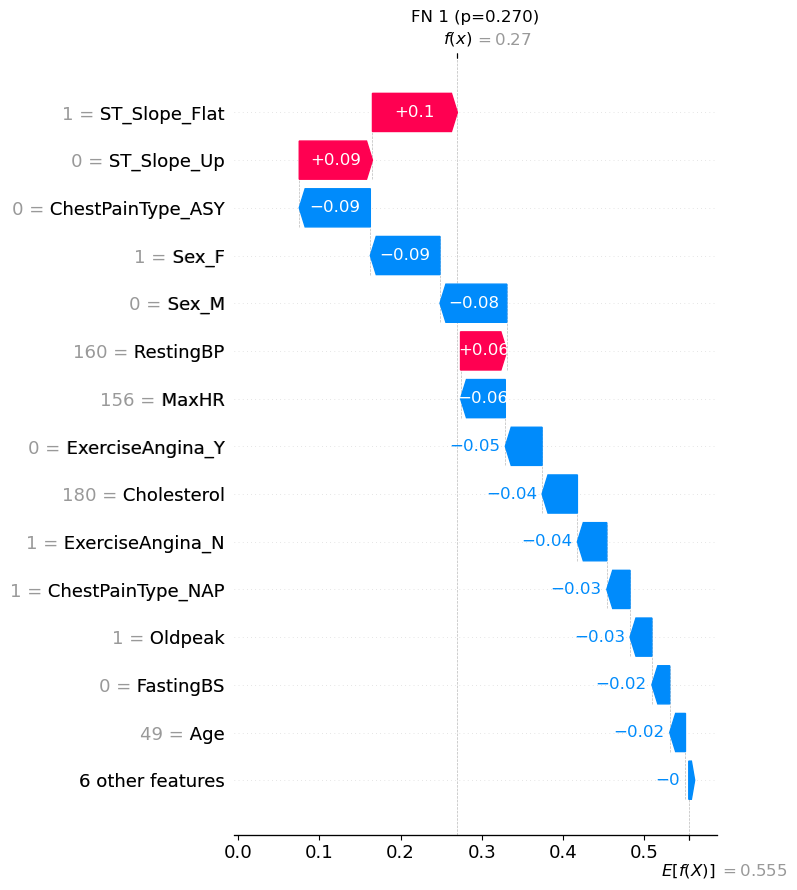

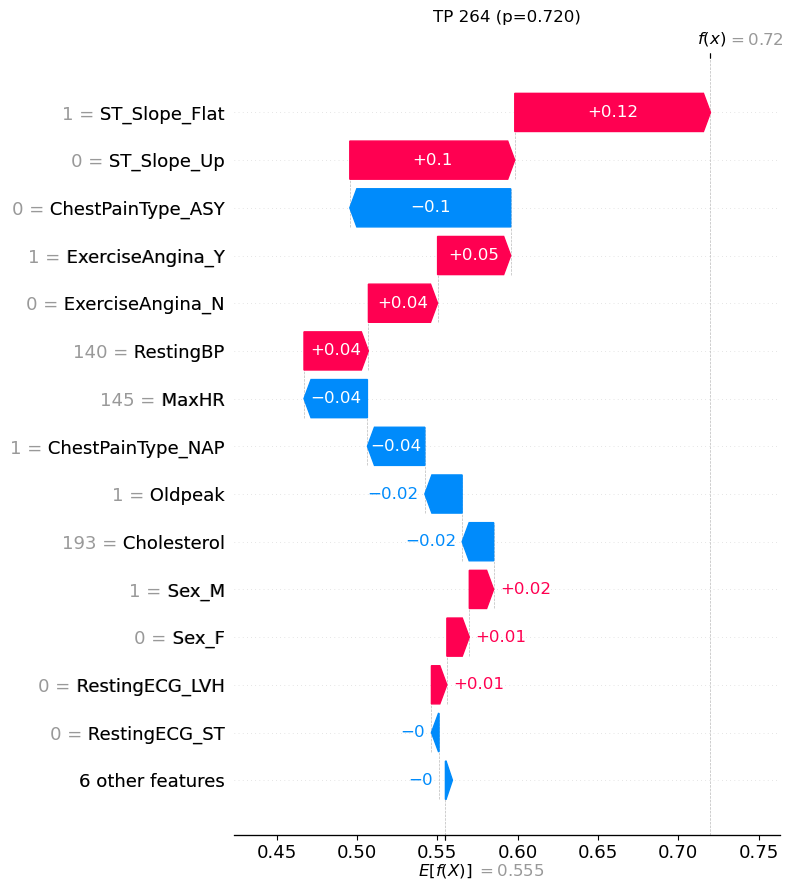

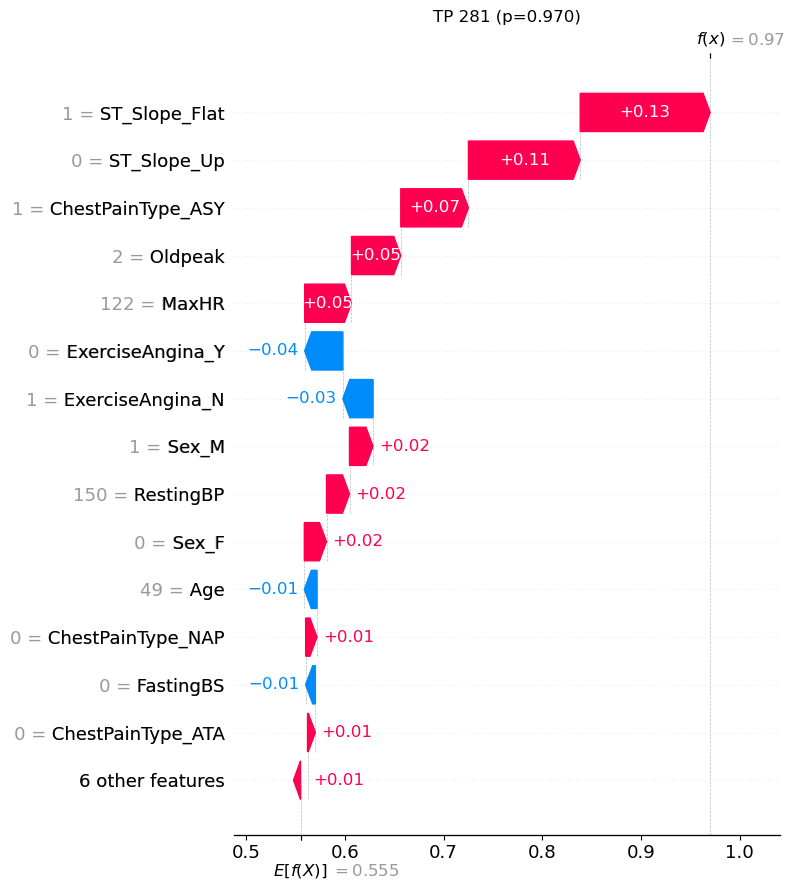

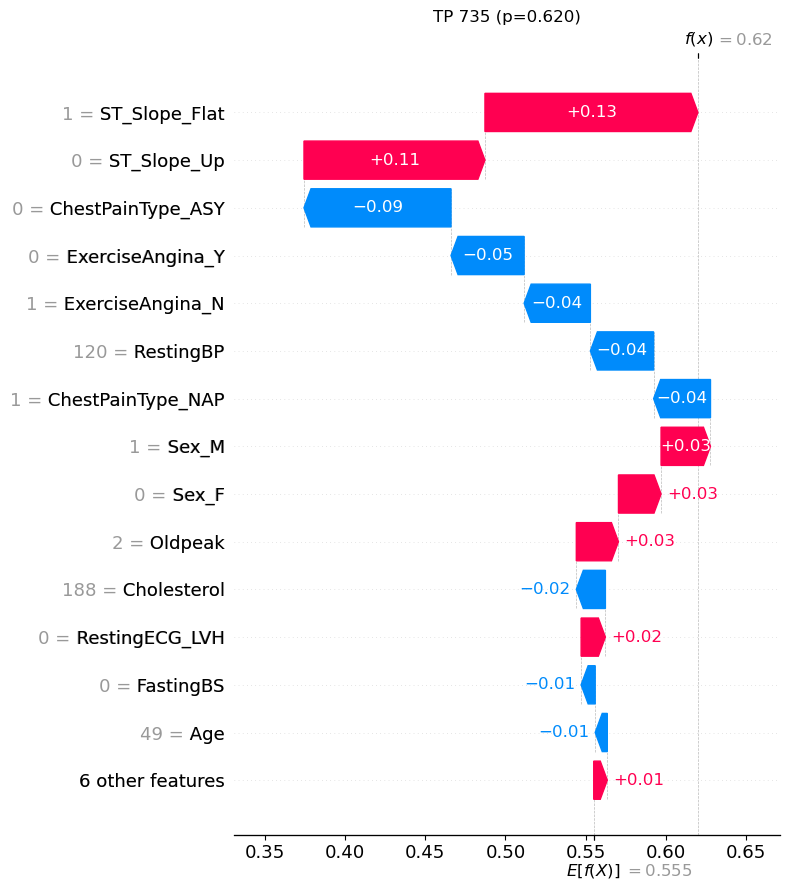

,feature,FN_val,FN_SHAP,TP1_264_val,TP1_264_SHAP,TP2_281_val,TP2_281_SHAP,TP3_735_val,TP3_735_SHAP,meanTP_SHAP,Delta_FN_minus_meanTP,abs_delta,delta_sign,fn_id
0,ST_Slope_Flat,1.0,0.105,1.0,0.122,1.0,0.132,1.0,0.133,0.129,-0.024,0.024,-1,1
1,ST_Slope_Up,0.0,0.090,0.0,0.103,0.0,0.113,0.0,0.113,0.110,-0.019,0.019,-1,1
2,ChestPainType_ASY,0.0,-0.088,0.0,-0.100,1.0,0.069,0.0,-0.092,-0.041,-0.046,0.046,-1,1
3,Sex_F,1.0,-0.086,0.0,0.014,0.0,0.022,0.0,0.027,0.021,-0.107,0.107,-1,1
4,Sex_M,0.0,-0.082,1.0,0.015,1.0,0.024,1.0,0.031,0.023,-0.106,0.106,-1,1
5,RestingBP,160.0,0.057,140.0,0.040,150.0,0.023,120.0,-0.039,0.008,0.049,0.049,1,1
6,MaxHR,156.0,-0.055,145.0,-0.039,122.0,0.047,139.0,0.004,0.004,-0.059,0.059,-1,1
7,ExerciseAngina_Y,0.0,-0.045,1.0,0.046,0.0,-0.039,0.0,-0.046,-0.013,-0.032,0.032,-1,1
8,Cholesterol,180.0,-0.043,193.0,-0.020,222.0,-0.003,188.0,-0.018,-0.013,-0.030,0.030,-1,1
9,ExerciseAngina_N,1.0,-0.036,0.0,0.043,1.0,-0.031,1.0,-0.041,-0.010,-0.027,0.027,-1,1


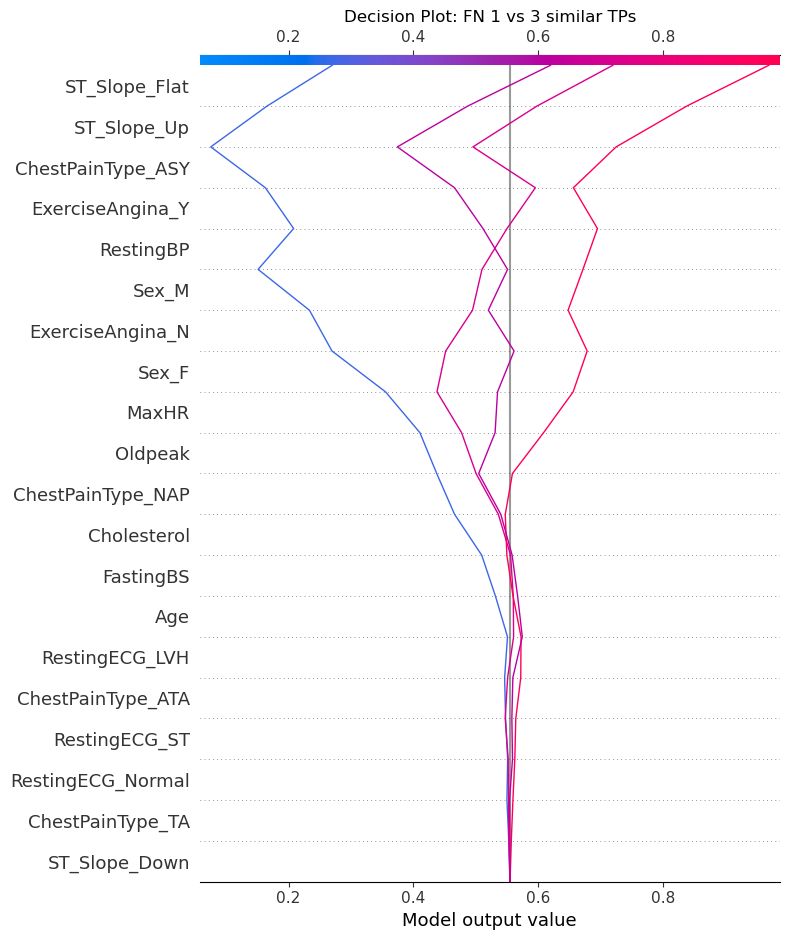

In [40]:
fn_id = 1

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table, matches2 = make_waterfall_compare_table(fn_id, k=3)

print(f"FN {fn_id} p(krank) =", float(fn_cases.loc[fn_id, "y_proba"]))
display(matches2)          # oder display(matches2[["fn_id","tp_id","rank","distance","tp_proba"]]) etc.
# Beispiel: nimm den FN mit der niedrigsten proba (oft spannend)
fn_id_example = fn_cases.sort_values("y_proba").index[4]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   # Tabelle zuerst

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)

## 3) FN_ID: 440

FN 440 p(krank) = 0.41


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
3,440,492,1,2.432686,0.41,0.70
4,440,735,2,3.261938,0.41,0.62
5,440,337,3,3.459791,0.41,0.69


FN: 440 proba: 0.41


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
3,440,492,1,2.432686,0.41,0.70
4,440,735,2,3.261938,0.41,0.62
5,440,337,3,3.459791,0.41,0.69


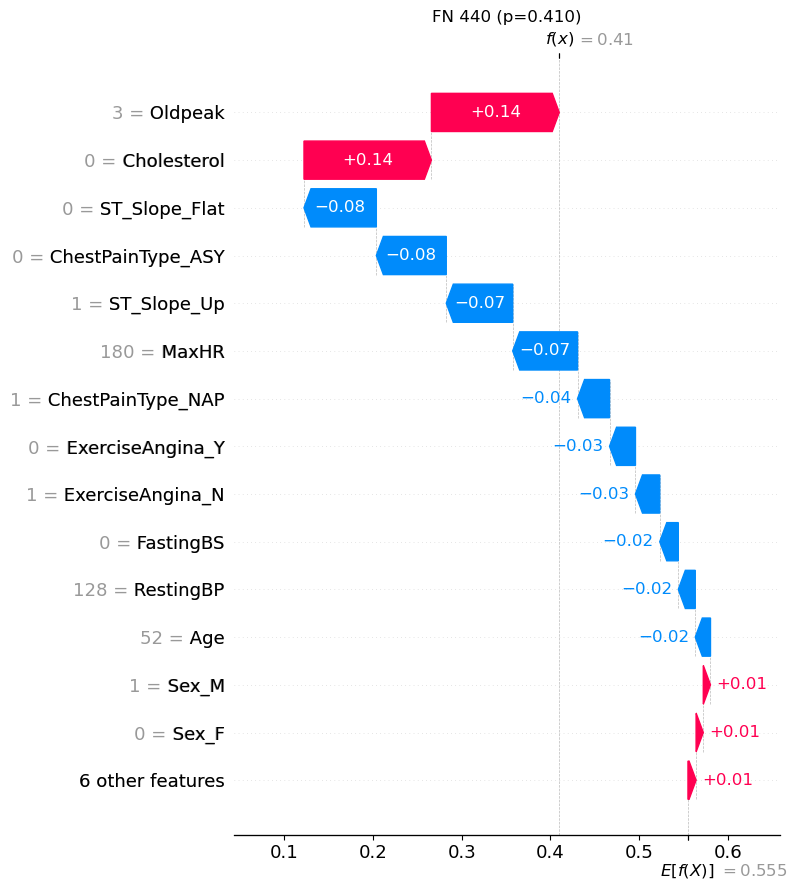

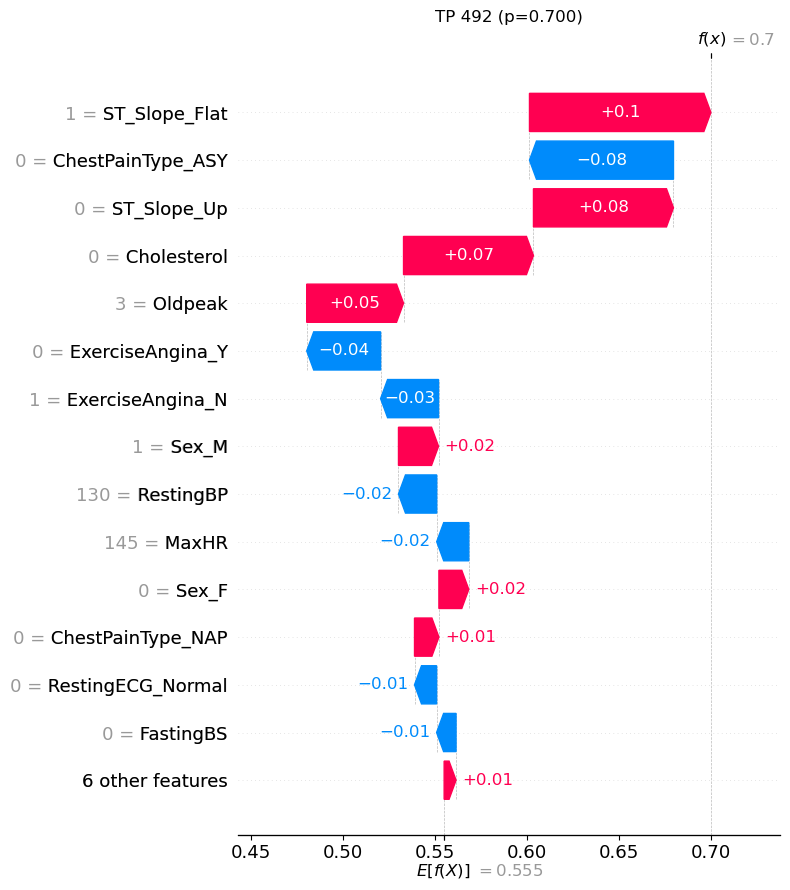

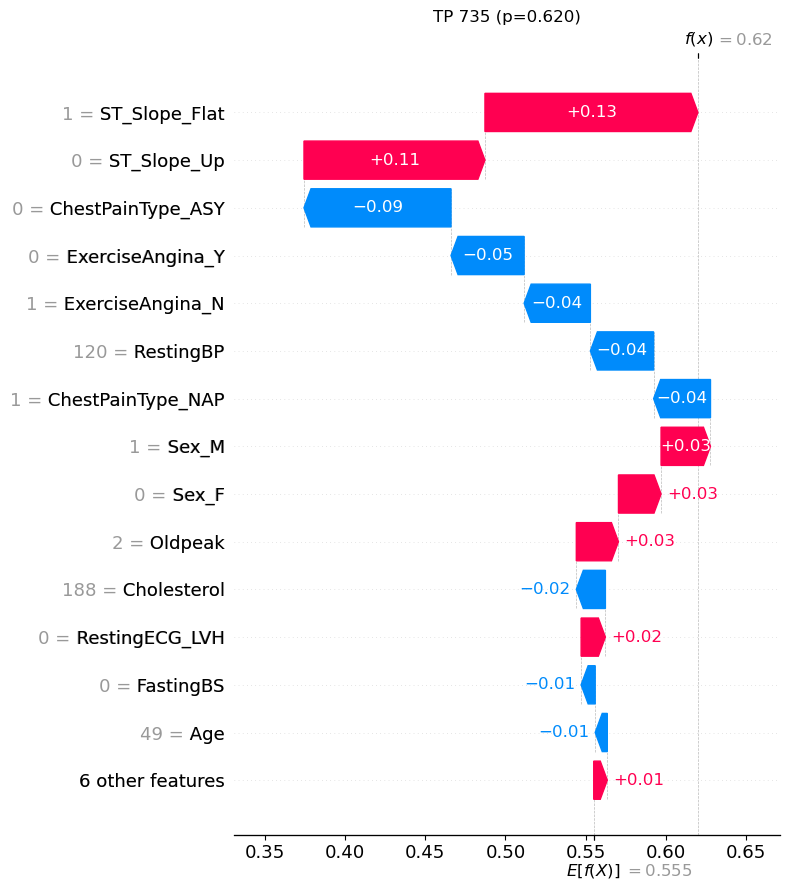

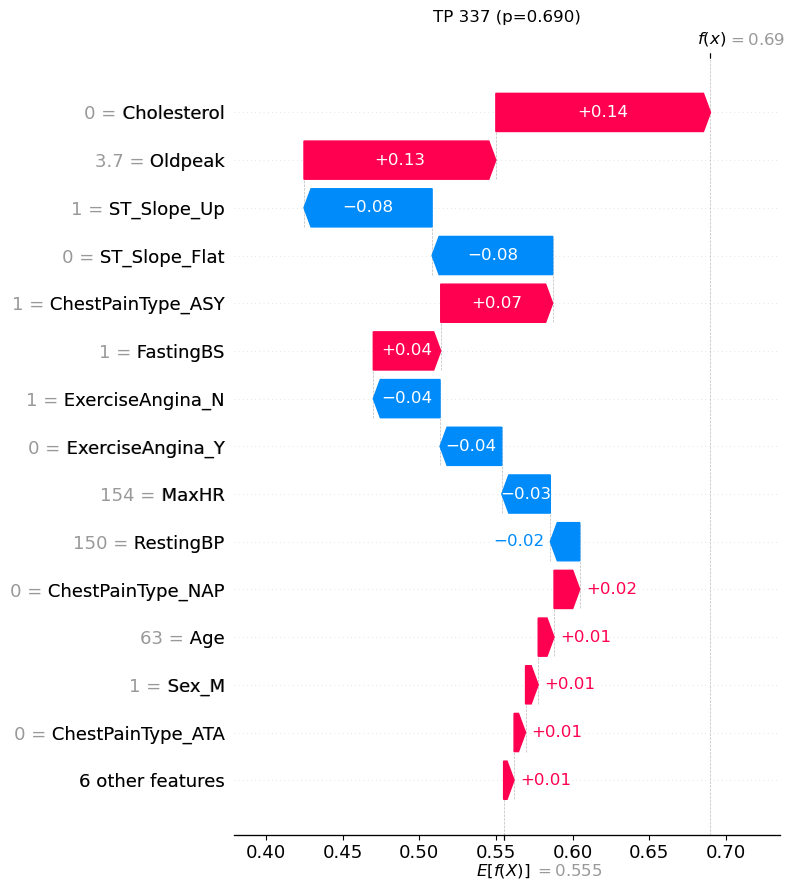

,feature,FN_val,FN_SHAP,TP1_492_val,TP1_492_SHAP,TP2_735_val,TP2_735_SHAP,TP3_337_val,TP3_337_SHAP,meanTP_SHAP,Delta_FN_minus_meanTP,abs_delta,delta_sign,fn_id
0,Cholesterol,0.0,0.144,0.0,0.071,188.0,-0.018,0.0,0.140,0.064,0.079,0.079,1,440
1,Oldpeak,3.0,0.144,3.0,0.053,2.0,0.026,3.7,0.125,0.068,0.076,0.076,1,440
2,ST_Slope_Flat,0.0,-0.082,1.0,0.099,1.0,0.133,0.0,-0.079,0.051,-0.132,0.132,-1,440
3,ChestPainType_ASY,0.0,-0.079,0.0,-0.078,0.0,-0.092,1.0,0.073,-0.032,-0.047,0.047,-1,440
4,ST_Slope_Up,1.0,-0.075,0.0,0.076,0.0,0.113,1.0,-0.084,0.035,-0.110,0.110,-1,440
5,MaxHR,180.0,-0.073,145.0,-0.017,139.0,0.004,154.0,-0.032,-0.015,-0.058,0.058,-1,440
6,ChestPainType_NAP,1.0,-0.036,0.0,0.013,1.0,-0.035,0.0,0.017,-0.002,-0.034,0.034,-1,440
7,ExerciseAngina_Y,0.0,-0.029,0.0,-0.040,0.0,-0.046,0.0,-0.040,-0.042,0.013,0.013,1,440
8,ExerciseAngina_N,1.0,-0.027,1.0,-0.031,1.0,-0.041,1.0,-0.044,-0.039,0.011,0.011,1,440
9,FastingBS,0.0,-0.021,0.0,-0.011,0.0,-0.009,1.0,0.044,0.008,-0.029,0.029,-1,440


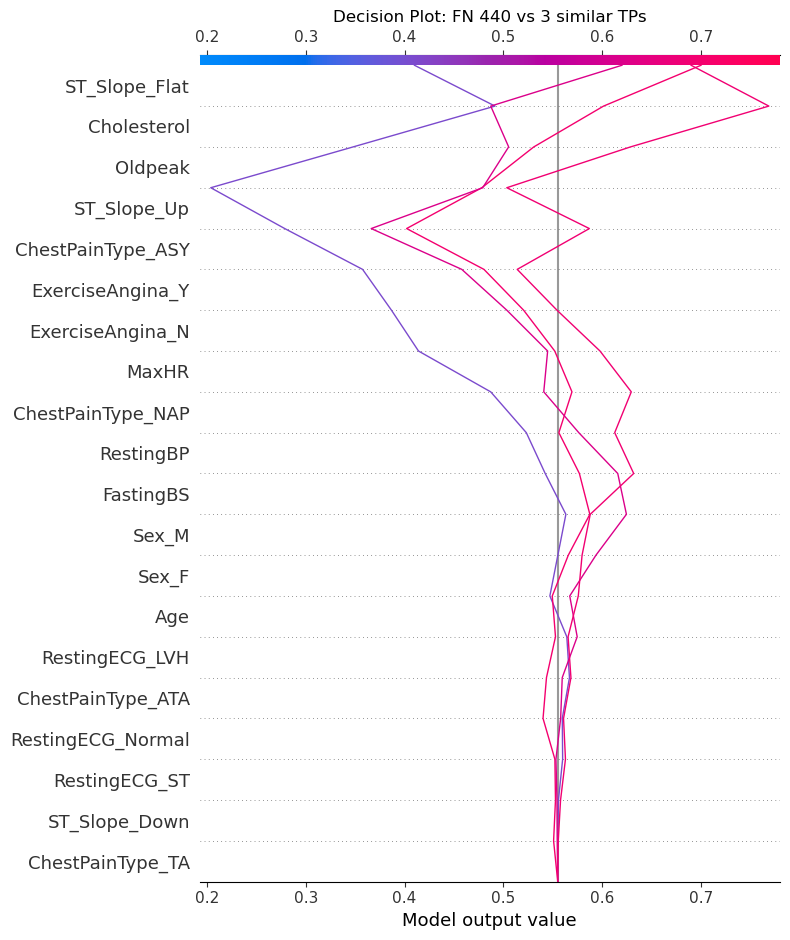

In [41]:
fn_id = 440

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table, matches2 = make_waterfall_compare_table(fn_id, k=3)

print(f"FN {fn_id} p(krank) =", float(fn_cases.loc[fn_id, "y_proba"]))
display(matches2)          # oder display(matches2[["fn_id","tp_id","rank","distance","tp_proba"]]) etc.
fn_id_example = fn_cases.sort_values("y_proba").index[5]
compare_fn_to_tps(fn_id_example, k=3)
display(waterfall_table)   # Tabelle zuerst

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)


## 4) FN_ID: 759

FN 759 p(krank) = 0.21


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
9,759,581,1,4.267965,0.21,0.74
10,759,585,2,4.388495,0.21,0.81
11,759,651,3,4.521571,0.21,0.89


,feature,FN_val,FN_SHAP,TP1_581_val,TP1_581_SHAP,TP2_585_val,TP2_585_SHAP,TP3_651_val,TP3_651_SHAP,meanTP_SHAP,Delta_FN_minus_meanTP,abs_delta,delta_sign,fn_id
0,ST_Slope_Flat,0.0,-0.114,0.0,-0.071,1.0,0.132,0.0,-0.066,-0.002,-0.112,0.112,-1,759
1,ST_Slope_Up,1.0,-0.105,1.0,-0.123,0.0,0.132,1.0,-0.110,-0.034,-0.072,0.072,-1,759
2,ChestPainType_ASY,0.0,-0.072,1.0,0.142,0.0,-0.067,1.0,0.120,0.065,-0.137,0.137,-1,759
3,RestingBP,192.0,0.067,140.0,-0.006,180.0,0.002,140.0,-0.003,-0.002,0.070,0.070,1,759
4,MaxHR,195.0,-0.048,159.0,-0.022,120.0,0.038,138.0,-0.012,0.001,-0.049,0.049,-1,759
5,ExerciseAngina_N,1.0,-0.033,0.0,0.119,1.0,-0.038,0.0,0.131,0.070,-0.103,0.103,-1,759
6,RestingECG_LVH,1.0,0.030,0.0,-0.002,0.0,0.013,1.0,0.003,0.005,0.025,0.025,1,759
7,ExerciseAngina_Y,0.0,-0.028,1.0,0.095,0.0,-0.024,1.0,0.116,0.062,-0.091,0.091,-1,759
8,Age,54.0,-0.025,48.0,-0.057,57.0,0.003,61.0,0.036,-0.006,-0.019,0.019,-1,759
9,Oldpeak,0.0,-0.021,1.5,0.067,0.8,-0.014,1.9,0.062,0.039,-0.060,0.060,-1,759


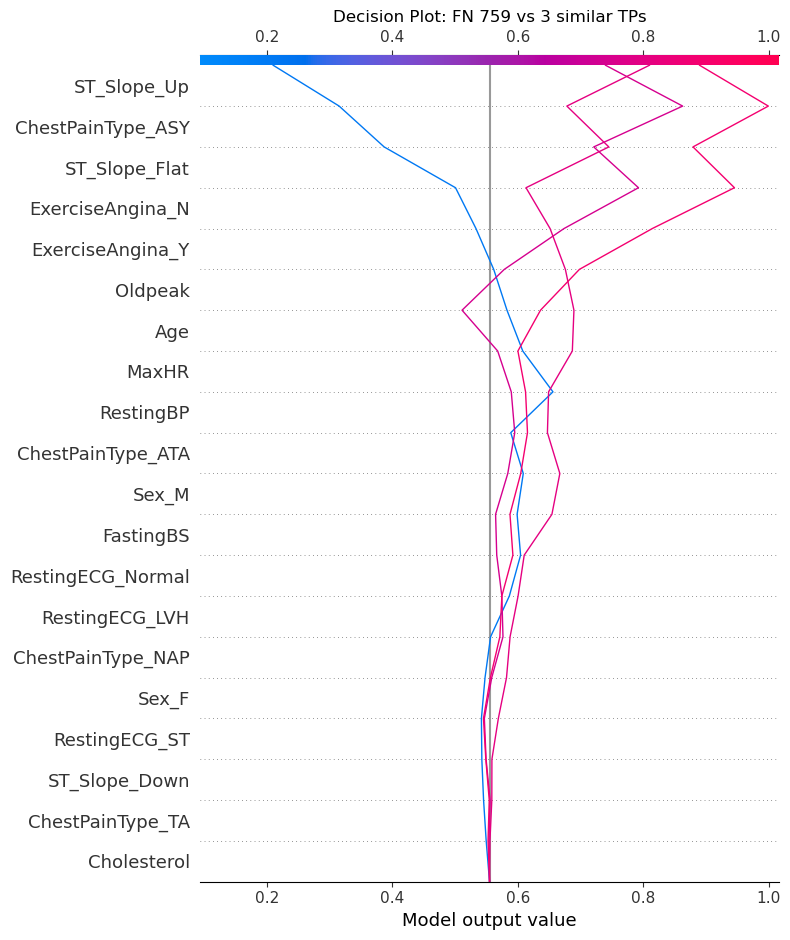

In [42]:
fn_id = 759

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table, matches2 = make_waterfall_compare_table(fn_id, k=3)

print(f"FN {fn_id} p(krank) =", float(fn_cases.loc[fn_id, "y_proba"]))
display(matches2)          # oder display(matches2[["fn_id","tp_id","rank","distance","tp_proba"]]) etc.
display(waterfall_table)   # Tabelle zuerst

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)


## 5) FN_ID: 763

FN 763 p(krank) = 0.25


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
12,763,786,1,2.429525,0.25,0.66
13,763,651,2,2.754583,0.25,0.89
14,763,735,3,2.890340,0.25,0.62


,feature,FN_val,FN_SHAP,TP1_786_val,TP1_786_SHAP,TP2_651_val,TP2_651_SHAP,TP3_735_val,TP3_735_SHAP,meanTP_SHAP,Delta_FN_minus_meanTP,abs_delta,delta_sign,fn_id
0,Oldpeak,3.2,0.150,2.0,0.052,1.9,0.062,2.0,0.026,0.047,0.103,0.103,1,763
1,ST_Slope_Flat,0.0,-0.111,1.0,0.123,0.0,-0.066,1.0,0.133,0.063,-0.174,0.174,-1,763
2,ST_Slope_Up,1.0,-0.098,0.0,0.105,1.0,-0.110,0.0,0.113,0.036,-0.134,0.134,-1,763
3,ChestPainType_ASY,0.0,-0.083,0.0,-0.094,1.0,0.120,0.0,-0.092,-0.022,-0.061,0.061,-1,763
4,MaxHR,173.0,-0.048,146.0,-0.021,138.0,-0.012,139.0,0.004,-0.010,-0.038,0.038,-1,763
5,ExerciseAngina_Y,0.0,-0.047,0.0,-0.039,1.0,0.116,0.0,-0.046,0.011,-0.057,0.057,-1,763
6,ExerciseAngina_N,1.0,-0.041,1.0,-0.049,0.0,0.131,1.0,-0.041,0.014,-0.054,0.054,-1,763
7,Age,58.0,0.030,69.0,0.004,61.0,0.036,49.0,-0.008,0.011,0.020,0.020,1,763
8,ChestPainType_NAP,1.0,-0.029,1.0,-0.048,0.0,0.015,1.0,-0.035,-0.023,-0.006,0.006,-1,763
9,Cholesterol,224.0,-0.027,254.0,-0.015,207.0,-0.002,188.0,-0.018,-0.012,-0.015,0.015,-1,763


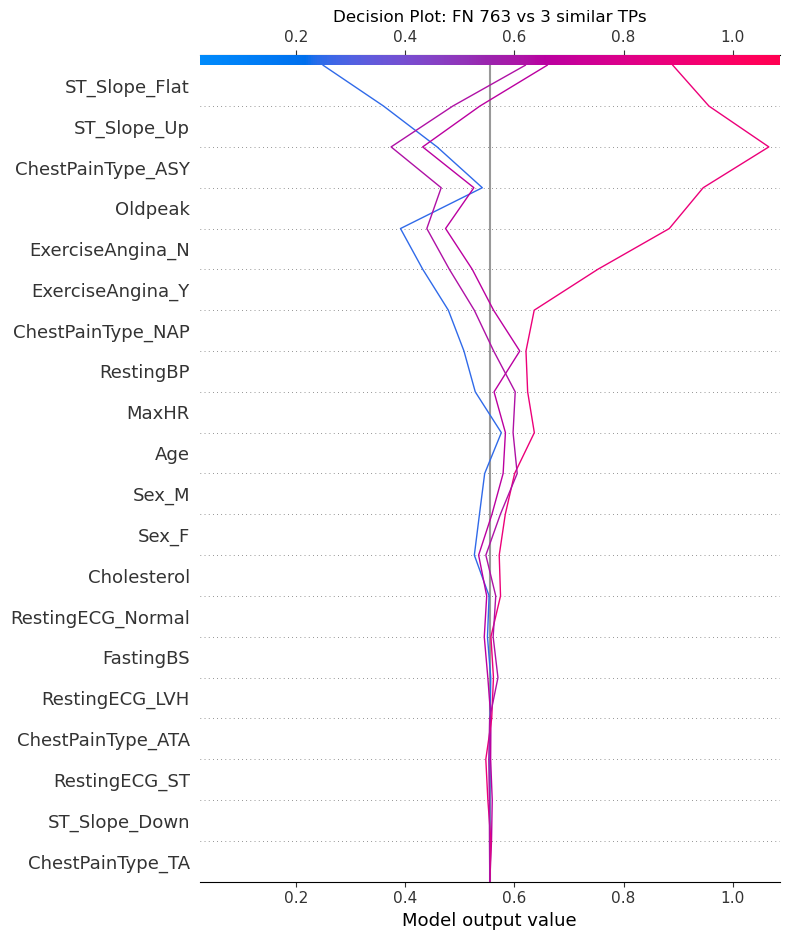

In [43]:
fn_id = 763

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table, matches2 = make_waterfall_compare_table(fn_id, k=3)

print(f"FN {fn_id} p(krank) =", float(fn_cases.loc[fn_id, "y_proba"]))
display(matches2)          # oder display(matches2[["fn_id","tp_id","rank","distance","tp_proba"]]) etc.
display(waterfall_table)   # Tabelle zuerst

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)


## 6) FN_ID: 889

FN 889 p(krank) = 0.08


,fn_id,tp_id,rank,distance,fn_proba,tp_proba
15,889,581,1,2.419694,0.08,0.74
16,889,735,2,2.772903,0.08,0.62
17,889,651,3,2.837886,0.08,0.89


,feature,FN_val,FN_SHAP,TP1_581_val,TP1_581_SHAP,TP2_735_val,TP2_735_SHAP,TP3_651_val,TP3_651_SHAP,meanTP_SHAP,Delta_FN_minus_meanTP,abs_delta,delta_sign,fn_id
0,ST_Slope_Up,1.0,-0.113,1.0,-0.123,0.0,0.113,1.0,-0.110,-0.040,-0.073,0.073,-1,889
1,ChestPainType_ASY,0.0,-0.107,1.0,0.142,0.0,-0.092,1.0,0.120,0.057,-0.164,0.164,-1,889
2,ST_Slope_Flat,0.0,-0.107,0.0,-0.071,1.0,0.133,0.0,-0.066,-0.002,-0.105,0.105,-1,889
3,MaxHR,162.0,-0.047,159.0,-0.022,139.0,0.004,138.0,-0.012,-0.010,-0.037,0.037,-1,889
4,ExerciseAngina_Y,0.0,-0.045,1.0,0.095,0.0,-0.046,1.0,0.116,0.055,-0.100,0.100,-1,889
5,ExerciseAngina_N,1.0,-0.044,0.0,0.119,1.0,-0.041,0.0,0.131,0.069,-0.113,0.113,-1,889
6,Cholesterol,204.0,-0.032,208.0,-0.001,188.0,-0.018,207.0,-0.002,-0.007,-0.025,0.025,-1,889
7,Age,59.0,0.025,48.0,-0.057,49.0,-0.008,61.0,0.036,-0.009,0.034,0.034,1,889
8,RestingBP,134.0,-0.015,140.0,-0.006,120.0,-0.039,140.0,-0.003,-0.016,0.001,0.001,1,889
9,Sex_M,1.0,0.013,1.0,0.019,1.0,0.031,1.0,0.017,0.022,-0.010,0.010,-1,889


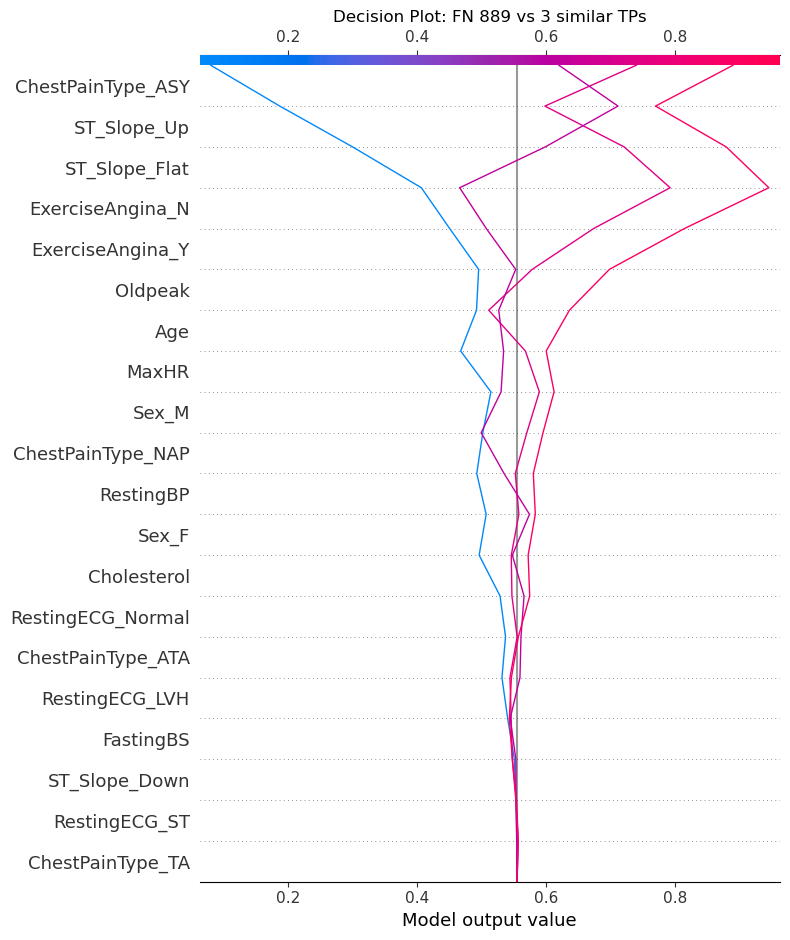

In [44]:
fn_id = 889

# 1) Tabelle (Top-8 Features nach |FN_SHAP|)
waterfall_table, matches2 = make_waterfall_compare_table(fn_id, k=3)

print(f"FN {fn_id} p(krank) =", float(fn_cases.loc[fn_id, "y_proba"]))
display(matches2)          # oder display(matches2[["fn_id","tp_id","rank","distance","tp_proba"]]) etc.
display(waterfall_table)   # Tabelle zuerst

# 2) Decision Plot (danach)
matches = plot_decision_for_fn_group(fn_id, k=3)


In [45]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# Helper: SHAP-Vektor (als Series) für eine Sample-ID holen
# ---------------------------------------------------------
def shap_row_for_index(sample_id, X_test_processed, shap_values_1):
    row_pos = X_test_processed.index.get_loc(sample_id)
    return pd.Series(shap_values_1[row_pos], index=X_test_processed.columns, name=sample_id)

# ---------------------------------------------------------
# Helper: erkennen, ob Feature "binary/OHE" ist (nur 0/1)
# ---------------------------------------------------------
def is_binary_ohe_feature(col_series: pd.Series) -> bool:
    s = col_series.dropna()
    if s.empty:
        return False
    # robust: erlaubt auch floats wie 0.0/1.0
    uniq = set(np.unique(s.values))
    return uniq.issubset({0, 1, 0.0, 1.0})

# ---------------------------------------------------------
# 1) Einzeltabelle pro FN: ALLE Features (FN vs mean(TPs))
#    + Sortierung nach FN_SHAP absteigend (wie du wolltest)
# ---------------------------------------------------------
def make_full_compare_table_for_fn(
    fn_id,
    knn_matches_df,
    X_test_processed,
    shap_values_1,
    k_neighbors=3,
    sort_by="FN_SHAP",          # oder "abs_FN_SHAP"
    ascending=False
):
    # passende TPs holen
    matches = (knn_matches_df[knn_matches_df["fn_id"] == fn_id]
               .sort_values("rank")
               .head(k_neighbors))
    tp_ids = matches["tp_id"].tolist()

    # --- Werte: FN + TPs
    fn_vals = X_test_processed.loc[fn_id]
    tp_vals = X_test_processed.loc[tp_ids]                 # (k, n_features)
    mean_tp_vals = tp_vals.mean(axis=0)                    # (n_features,)

    # --- SHAP: FN + TPs
    fn_shap = shap_row_for_index(fn_id, X_test_processed, shap_values_1)
    tp_shaps = pd.concat(
        [shap_row_for_index(tp_id, X_test_processed, shap_values_1) for tp_id in tp_ids],
        axis=1
    )
    mean_tp_shap = tp_shaps.mean(axis=1)

    # --- Delta
    delta = fn_shap - mean_tp_shap

    df = pd.DataFrame({
        "feature": X_test_processed.columns,
        "FN_val": fn_vals.values,
        "meanTP_val": mean_tp_vals.values,
        "FN_SHAP": fn_shap.values,
        "meanTP_SHAP": mean_tp_shap.values,
        "Delta_FN_minus_meanTP": delta.values,
        "abs_FN_SHAP": np.abs(fn_shap.values),
        "abs_Delta": np.abs(delta.values),
        "fn_id": fn_id
    })

    # optisch runden
    df["FN_SHAP"] = df["FN_SHAP"].astype(float).round(3)
    df["meanTP_SHAP"] = df["meanTP_SHAP"].astype(float).round(3)
    df["Delta_FN_minus_meanTP"] = df["Delta_FN_minus_meanTP"].astype(float).round(3)

    # Werte runden: OHE schön als int, numerisch bleibt float
    # (wir machen das dynamisch in der Meta später sauber)
    # hier nur leicht hübsch:
    df["FN_val"] = df["FN_val"].astype(float)
    df["meanTP_val"] = df["meanTP_val"].astype(float)

    # Sortierung
    if sort_by == "abs_FN_SHAP":
        df = df.sort_values("abs_FN_SHAP", ascending=ascending).reset_index(drop=True)
    else:
        df = df.sort_values("FN_SHAP", ascending=ascending).reset_index(drop=True)

    return df, matches, tp_ids

# ---------------------------------------------------------
# 2) Meta-Tabelle über alle FNs (ohne Vermischen)
#    - OHE/Binary: getrennte Zeilen Feature=0 / Feature=1
#    - Numerisch: eine Zeile pro Feature
#    + inkl. mean FN_val / mean TP_val
# ---------------------------------------------------------
def build_meta_table_over_all_fns_no_mixing(
    fn_ids,
    knn_matches_df,
    X_test_processed,
    shap_values_1,
    k_neighbors=3
):
    # welche Features sind binary/ohe?
    binary_mask = {col: is_binary_ohe_feature(X_test_processed[col]) for col in X_test_processed.columns}

    all_rows = []
    for fn_id in fn_ids:
        per_fn_df, matches, tp_ids = make_full_compare_table_for_fn(
            fn_id=fn_id,
            knn_matches_df=knn_matches_df,
            X_test_processed=X_test_processed,
            shap_values_1=shap_values_1,
            k_neighbors=k_neighbors,
            sort_by="FN_SHAP",
            ascending=False
        )

        # Key bauen: bei binary => "feature=FN_val" sonst nur "feature"
        # dadurch werden z.B. ST_Slope_Up=0 und ST_Slope_Up=1 NICHT vermischt
        def make_key(row):
            feat = row["feature"]
            if binary_mask.get(feat, False):
                # FN_val kann float sein -> sauber zu int
                v = int(round(float(row["FN_val"])))
                return f"{feat}={v}"
            else:
                return feat

        per_fn_df["meta_key"] = per_fn_df.apply(make_key, axis=1)

        # Vorzeichen für Konsistenz
        per_fn_df["delta_sign"] = np.sign(per_fn_df["Delta_FN_minus_meanTP"].astype(float)).astype(int)

        all_rows.append(per_fn_df)

    long_df = pd.concat(all_rows, ignore_index=True)

    # sign consistency: Anteil der Deltas, die das Mehrheits-Vorzeichen haben
    def sign_consistency(x: pd.Series) -> float:
        counts = x.value_counts()
        return float(counts.max() / counts.sum()) if counts.sum() else np.nan

    meta = (long_df.groupby(["meta_key"], as_index=False)
            .agg(
                feature=("feature", "first"),
                is_binary=("feature", lambda s: bool(binary_mask.get(s.iloc[0], False))),

                # wie oft kommt es in den 6 FN-Fällen vor?
                # (bei full tables ist es immer 6, bei binary getrennt ebenfalls 6,
                #  aber du siehst damit sofort, wenn du später filterst)
                freq=("fn_id", "nunique"),

                # Werte (das wolltest du explizit)
                mean_FN_val=("FN_val", "mean"),
                mean_meanTP_val=("meanTP_val", "mean"),

                # SHAP / Delta Kennzahlen
                mean_FN_SHAP=("FN_SHAP", "mean"),
                mean_meanTP_SHAP=("meanTP_SHAP", "mean"),
                mean_delta=("Delta_FN_minus_meanTP", "mean"),
                mean_abs_delta=("Delta_FN_minus_meanTP", lambda x: np.mean(np.abs(x.astype(float)))),

                sign_consistency=("delta_sign", sign_consistency),
            ))

    # Formatierung
    n_fns = len(fn_ids)
    meta["freq"] = meta["freq"].astype(int).astype(str) + f"/{n_fns}"
    meta["sign_consistency"] = (meta["sign_consistency"] * 100).round(0).astype(int).astype(str) + " %"

    # runden
    for c in ["mean_FN_val", "mean_meanTP_val", "mean_FN_SHAP", "mean_meanTP_SHAP", "mean_delta", "mean_abs_delta"]:
        meta[c] = meta[c].astype(float).round(3)

    # bei binary: mean_FN_val / mean_meanTP_val eher als Anteil interpretierbar
    # -> optional zusätzlich als "rate" labeln, aber wir lassen es numerisch
    # Sortierung nach mean_abs_delta (wichtigste Kipp-Features oben)
    meta = meta.sort_values("mean_abs_delta", ascending=False).reset_index(drop=True)

    return meta, long_df




In [46]:
# ---------------------------------------------------------
# 3) AUSFÜHRUNG
# ---------------------------------------------------------
fn_ids = fn_cases.index.tolist()     # deine 6 FN-IDs
K_NEIGHBORS = 3

meta_table, long_table = build_meta_table_over_all_fns_no_mixing(
    fn_ids=fn_ids,
    knn_matches_df=knn_matches_df,
    X_test_processed=X_test_processed,
    shap_values_1=shap_values_1,
    k_neighbors=K_NEIGHBORS
)

display(meta_table)

,meta_key,feature,is_binary,freq,mean_FN_val,mean_meanTP_val,mean_FN_SHAP,mean_meanTP_SHAP,mean_delta,mean_abs_delta,sign_consistency
0,ST_Slope_Flat=0,ST_Slope_Flat,True,5/6,0.000,0.600,-0.109,0.048,-0.156,0.156,100 %
1,ST_Slope_Up=1,ST_Slope_Up,True,5/6,1.000,0.400,-0.106,0.023,-0.129,0.129,100 %
2,Sex_F=1,Sex_F,True,1/6,1.000,0.000,-0.086,0.021,-0.107,0.107,100 %
3,Sex_M=0,Sex_M,True,1/6,0.000,1.000,-0.082,0.023,-0.106,0.106,100 %
4,ChestPainType_ASY=0,ChestPainType_ASY,True,6/6,0.000,0.500,-0.084,0.008,-0.092,0.092,100 %
5,Oldpeak,Oldpeak,False,6/6,1.333,1.733,0.036,0.039,-0.003,0.063,67 %
6,ExerciseAngina_N=1,ExerciseAngina_N,True,6/6,1.000,0.611,-0.036,0.016,-0.051,0.055,83 %
7,ExerciseAngina_Y=0,ExerciseAngina_Y,True,6/6,0.000,0.389,-0.038,0.010,-0.048,0.053,83 %
8,MaxHR,MaxHR,False,6/6,169.667,140.722,-0.051,-0.003,-0.048,0.049,100 %
9,RestingBP,RestingBP,False,6/6,142.333,134.333,0.010,-0.010,0.020,0.028,83 %


## Aggregierte XAI-Analyse über alle False-Negative-Fälle

Die lokale XAI-Analyse einzelner False-Negative-Fälle liefert wertvolle Einblicke in konkrete Fehlentscheidungen des Modells. Eine vollständige, detaillierte Interpretation aller sechs False Negatives würde jedoch zu starken Redundanzen führen, da sich viele Muster wiederholen und einzelne Effekte nur schwer vergleichbar wären.

Stattdessen wird im Folgenden eine **aggregierte Meta-Tabelle** betrachtet, die die lokalen SHAP-Ergebnisse **über alle sechs False-Negative-Fälle hinweg zusammenfasst**. Ziel dieser Aggregation ist es, **systematische Kippfaktoren** zu identifizieren – also Merkmale, die über mehrere Fälle hinweg konsistent zur Fehlklassifikation beitragen.

Um eine Vermischung unterschiedlicher Feature-Zustände zu vermeiden, werden **binäre bzw. One-Hot-Encoded Features getrennt nach ihrem tatsächlichen Wert (0 oder 1)** aggregiert. Dadurch lassen sich Aussagen wie *„Feature X wirkt problematisch, wenn es aktiv ist“* klar von *„Feature X wirkt problematisch, wenn es nicht aktiv ist“* unterscheiden.

Die Meta-Tabelle basiert auf vollständigen lokalen Vergleichstabellen (False Negative vs. Mittelwert der jeweils drei ähnlichsten True Positives) und fasst deren Informationen featureweise zusammen.

---

## Bedeutung der Spalten in der Meta-Tabelle

Im Folgenden werden die einzelnen Spalten der Meta-Tabelle erläutert:

- **`feature`**  
  Name des betrachteten Features. Bei binären Features entspricht dieser der ursprünglichen Spaltenbezeichnung aus dem Modellinput.

- **`freq`**  
  Anzahl der False-Negative-Fälle, in denen dieses Feature (bzw. dieser Feature-Zustand) auftritt.  
  Die Angabe erfolgt relativ zur Gesamtzahl der False Negatives. Sprich wenn das Feature ST_Slope_Flat=0 eine freq von `5/6` hat bedeutet das, dass in  5 von den insgesamt 6 False-Negative-Fällen das Feature den Wert = 0 hatte.
  

- **`mean_FN_val`**  
  Durchschnittlicher Feature-Wert über alle betrachteten False-Negative-Fälle.  

- **`mean_meanTP_val`**  
  Durchschnittlicher Feature-Wert der jeweils zugeordneten True-Positive-Vergleichsfälle.  
  Dieser Wert dient als Referenz, um zu beurteilen, **ob sich False Negatives systematisch von ähnlichen True Positives unterscheiden**.

- **`mean_FN_SHAP`**  
  Mittlerer SHAP-Wert des Features über alle False-Negative-Fälle.  
  Er beschreibt, **in welche Richtung und mit welcher Stärke** das Feature die Modellvorhersage bei False Negatives beeinflusst.

- **`mean_meanTP_SHAP`**  
  Durchschnittlicher SHAP-Wert desselben Features bei den zugehörigen True-Positive-Fällen.  
  Dieser Wert zeigt, wie das Modell dasselbe Feature **bei korrekt klassifizierten, ähnlichen Patienten nutzt**.

- **`mean_delta`**

 $$
\text{mean\_delta}
= \frac{1}{N} \sum_{i=1}^{N}
\left( \text{FN\_SHAP}_i - \overline{\text{TP\_SHAP}_i} \right)
$$

  Der mittlere Delta-Wert beschreibt die durchschnittliche Differenz zwischen dem SHAP-Wert eines Features bei False Negatives und dem mittleren SHAP-Wert desselben Features bei den zugehörigen True-Positive-Fällen  
  
  Das Vorzeichen von `mean_delta` gibt die **Richtung des systematischen Effekts** im Mittel an:
  - ein **negativer Wert** bedeutet, dass das Feature die Vorhersage bei False Negatives im Mittel stärker in Richtung „gesund“ verschiebt als bei ähnlichen True Positives,
  - ein **positiver Wert** entsprechend stärker in Richtung „krank“.

  `mean_delta` beantwortet somit die Frage, **in welche Richtung ein Feature zur Fehlklassifikation im Durchschnitt beiträgt**, sagt jedoch noch nichts darüber aus, **wie stark** dieser Effekt ist.

- **`mean_abs_delta`**

$$
\text{mean\_abs\_delta}
= \frac{1}{N} \sum_{i=1}^{N}
\left| \text{FN\_SHAP}_i - \overline{\text{TP\_SHAP}_i} \right|
$$



  Der Wert `mean_abs_delta` ist der Mittelwert der **absoluten** Delta-Werte über alle betrachteten False-Negative-Fälle:

  Diese Kennzahl misst **die Stärke der Abweichung zwischen False Negatives und vergleichbaren True Positives**, unabhängig von der Richtung.  
  Sie beantwortet die zentrale Frage der Meta-Analyse:

  > *Wie stark unterscheidet sich die Nutzung dieses Features bei Fehlklassifikationen von der Nutzung bei korrekten Klassifikationen?*

  `mean_abs_delta` ist daher die **zentrale Wichtigkeitsmetrik** der Meta-Tabelle. Features mit hohen Werten weisen auf **systematische Modellinkonsistenzen** hin: Das Modell behandelt sie bei sehr ähnlichen Patienten deutlich unterschiedlich – ein typisches Muster für Kippfaktoren von Fehlentscheidungen.

  Im Gegensatz dazu wäre `mean_FN_SHAP` **keine geeignete Hauptmetrik**, da ein hoher oder niedriger SHAP-Wert allein nicht aussagt, ob ein Feature zur Fehlklassifikation beiträgt. Ein Feature kann bei False Negatives einen starken SHAP-Effekt haben, aber **in gleicher Weise auch bei True Positives wirken**. Erst der Vergleich beider Gruppen über das Delta macht sichtbar, ob ein Feature tatsächlich **fehlerrelevant** ist.


- **`sign_consistency`**  
  Anteil der False-Negative-Fälle, in denen das Delta dasselbe Vorzeichen aufweist. Die Kennzahl sign_consistency gibt an, in wie vielen False-Negative-Fällen das **Mean_Delta** dasselbe Vorzeichen hat.

Mechanisch passiert Folgendes:

Man nimmt alle Deltas, die zu dieser Meta-Zeile gehören
(also alle FN-Fälle mit z.B. RestingECG_LVH = 1)

Man schaut bei jedem Delta nur:

positiv?

negativ?

Man zählt, welches Vorzeichen am häufigsten vorkommt

Der Anteil dieses Mehrheits-Vorzeichens ist die sign_consistency

Dieser Anteil entspricht der sign_consistency.

Einfaches Beispiel

Angenommen, ein Feature tritt in 5 False-Negative-Fällen auf und die berechneten Delta-Werte lauten:

−0.10

−0.12

−0.08

+0.02

−0.06

Dann gilt:

negative Deltas: 4

positive Deltas: 1

Die sign_consistency beträgt in diesem Fall =80%. In ca. 80 % der relevanten False-Negative-Fälle waren die einzelnen Delta-Werte negativ.

Hohe Werte (z. B. `100 %`) deuten auf einen **stabilen, gerichteten Effekt** hin, während niedrigere Werte auf **kontextabhängige oder instabile Feature-Wirkungen** schließen lassen.

---

## Warum mean_abs_delta die geeignete Metrik für die Meta-Analyse ist

Ziel der vorliegenden Analyse ist es nicht, allgemein wichtige Features des Modells zu identifizieren, sondern jene Merkmale zu finden, **die systematisch zur Entstehung von False-Negative-Fehlklassifikationen beitragen**. Entscheidend ist daher nicht, wie stark ein Feature im Durchschnitt bei False-Negative-Fällen wirkt, sondern **wie stark sich seine Nutzung bei Fehlklassifikationen von der Nutzung bei vergleichbaren korrekt klassifizierten Fällen unterscheidet**.

### Abgrenzung zu mean_FN_SHAP

Die Kennzahl **mean_FN_SHAP** beschreibt den durchschnittlichen SHAP-Wert eines Features über alle betrachteten False-Negative-Fälle. Sie beantwortet somit die Frage, *wie ein Feature im Mittel bei Fehlklassifikationen wirkt*, berücksichtigt jedoch **nicht**, ob dieses Verhalten spezifisch für Fehlklassifikationen ist oder ebenso bei korrekt klassifizierten Fällen auftritt.

Ein Feature kann beispielsweise bei False Negatives einen deutlich negativen SHAP-Wert aufweisen, jedoch bei vergleichbaren True-Positive-Fällen einen sehr ähnlichen Effekt haben. In diesem Fall ist das Feature zwar wichtig für die Modellentscheidung, **trägt aber nicht zur Erklärung des Fehlers bei**. mean_FN_SHAP allein kann diese Unterscheidung nicht leisten.

### Abgrenzung zu mean_delta

Die Kennzahl **mean_delta** misst den durchschnittlichen Unterschied zwischen dem SHAP-Wert eines Features bei False Negatives und dem mittleren SHAP-Wert desselben Features bei den zugehörigen True-Positive-Nachbarn. Sie gibt damit an, **in welche Richtung ein Feature im Durchschnitt zur Fehlklassifikation beiträgt**.

Allerdings kann mean_delta durch gegenläufige Effekte verzerrt werden: Wenn ein Feature in manchen False-Negative-Fällen stärker in Richtung „gesund“ und in anderen stärker in Richtung „krank“ wirkt, können sich diese Effekte gegenseitig aufheben. In diesem Fall ist mean_delta nahe null, obwohl das Feature in einzelnen Fällen einen erheblichen Einfluss auf die Modellentscheidung hat.

### Bedeutung von mean_abs_delta

Die Kennzahl **mean_abs_delta** behebt diese Einschränkungen, indem sie den **Mittelwert der absoluten Unterschiede** zwischen FN-SHAP-Werten und den zugehörigen TP-SHAP-Mittelwerten betrachtet. Sie misst somit **die Stärke der Abweichung**, unabhängig von deren Richtung.

Ein Beispiel aus den vorliegenden Daten ist das Feature *ST_Slope_Flat = 0*. Für dieses Feature zeigen sich in mehreren False-Negative-Fällen deutlich negative Delta-Werte (z. B. −0.105, −0.174, −0.112, −0.132, −0.259). Der daraus resultierende **mean_abs_delta-Wert von 0.156** zeigt, dass das Modell dieses Feature bei False Negatives **systematisch anders nutzt** als bei sehr ähnlichen korrekt klassifizierten Patienten. Dieser Unterschied wäre mit mean_FN_SHAP allein nicht erkennbar und könnte durch mean_delta im Fall gemischter Vorzeichen unterschätzt werden.

### Zusammenfassung

**mean_abs_delta** ist die zentrale Metrik der Meta-Analyse, da sie direkt misst, **wie stark sich die Modellnutzung eines Features bei Fehlklassifikationen von der Nutzung bei vergleichbaren korrekten Klassifikationen unterscheidet**. Sie ist damit besonders geeignet, **systematische Modellinkonsistenzen und Kippfaktoren von Fehlentscheidungen** zu identifizieren und liefert robustere Hinweise als sowohl **mean_FN_SHAP** als auch **mean_delta**.

